# imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from obspy.core.trace import Trace, Stats
from obspy.core.stream import Stream
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

from obspy.imaging.beachball import beachball
from obspy.imaging.beachball import beach
from obspy.imaging.source import plot_radiation_pattern

from matplotlib.patches import Rectangle
import matplotlib.patches

client = Client("IRIS")

In [2]:
%matplotlib notebook

# ZNE plot func def

In [34]:
def waveforms(start, end, adjtime):
    st_raw = client.get_waveforms("XB", "ELYSE", "02", "B*", start-(adjtime/2), end+adjtime, attach_response=True)
    st_disp = st_raw.copy()
    st_disp.remove_response(output='DISP')
    st_disp.filter('bandpass',freqmin=0.125, freqmax=1.0,corners=4, zerophase=True)
    return st_disp

def rotate(c1,c2,a):
    """
    IN: c1,c2 (arrays) and a (angle)
    c1 c2 are the X and Y axes, respectively of a Cartesian coordinate system
    a is an angle in degrees, positive angle means a clockwise rotation of the coordinate system.
    OUT: o1, o2 (arrays)
    o1 o2 are the X and Y axes, respectively of a rotated Cartesian coordinate system
    """
    o1 = np.cos(np.radians(a))*c1 - np.sin(np.radians(a))*c2
    o2 = np.sin(np.radians(a))*c1 + np.cos(np.radians(a))*c2
    return o1, o2

def uvw2enz(st,angles):
    BAz = angles[0]
    Pincd = angles[1]
    Sincd = angles[2]
    
    if len(st) != 3:
       print('Stream does not contain 3 Traces')
       return st
    for trace in st:
        head = trace.stats
        channel = head.channel
        if channel == 'BHU': U = trace.data
        elif channel == 'BHV': V = trace.data
        elif channel == 'BHW': W = trace.data
        else:
            print('Trace.channel is not BHU, BHV, or BHW')
            return st

    d = np.radians(-30)
    aU = np.radians(135)
    aV = np.radians(15)
    aW = np.radians(255)

    A = np.array([[np.cos(d)*np.sin(aU),np.cos(d)*np.cos(aU),-np.sin(d)],
                  [np.cos(d)*np.sin(aV), np.cos(d)*np.cos(aV), -np.sin(d)],
                  [np.cos(d)*np.sin(aW), np.cos(d)*np.cos(aW), -np.sin(d)]])

    B = np.linalg.inv(A)
    E,N,Z = np.dot(B,(U,V,W))

    head.channel = 'BHE'; trE = Trace(data=E, header=head)
    head.channel = 'BHN'; trN = Trace(data=N, header=head)
    head.channel = 'BHZ'; trZ = Trace(data=Z, header=head)
    stENZ = Stream(traces=[trE,trN,trZ])
    
    hhe = stENZ[0].data
    hhn = stENZ[1].data
    hhz = stENZ[2].data

    #hhT,hhR = rotate(hhe,hhn,BAz)
    #head.channel = 'BHT'; trT = Trace(data=hhT, header=head)
    #head.channel = 'BHR'; trR = Trace(data=hhR, header=head)
    
    #phhQ,phhL = rotate(hhn,hhz,Pincd)
    #shhQ,shhL = rotate(hhn,hhz,Sincd)
    #head.channel = 'BHL'; trL = Trace(data=phhL, header=head)
    #head.channel = 'BHQ'; trQ = Trace(data=shhQ, header=head)
    
    hhT,hhR = rotate(trE,trN,BAz)
    head.channel = 'BHT'; trT = Trace(data=hhT, header=head)
    head.channel = 'BHR'; trR = Trace(data=hhR, header=head)
    
    phhQ,phhL = rotate(trR,trZ,Pincd)
    shhQ,shhL = rotate(trR,trZ,Sincd)
    head.channel = 'BHL'; trL = Trace(data=phhL, header=head)
    head.channel = 'BHQ'; trQ = Trace(data=shhQ, header=head)
    
    stALL = Stream(traces=[trE,trN,trZ,trT,trR,trL,trQ])
    
    return stALL


def wfplot(event,axs,st,angs,Pt,St,Ptime=0):
    if Ptime == 0: Ptime = st[0].stats.starttime
    time_axis = st[0].times(reftime=Ptime)
    n = min([len(time_axis)]+[len(st[i].data) for i in np.arange(len(st))])

    sENZ = uvw2enz(st,angs)
    sENZ.plot()
    shift = 0; a = 1.0e9; iax = 0
    for trace in sENZ:
        axs[iax][0].plot(time_axis[:n], a*trace.data[:n],lw=0.5, label = event + ": " + trace.stats.channel)
        axs[iax][0].annotate(trace.stats.channel, xy=(Pt-10,shift+0.5), size='x-small', color='k')
        axs[iax][0].vlines(Pt,-3,3,color='k',linestyle='--',lw=1,alpha=0.5)
        axs[iax][0].set_xlim(Pt-15,Pt+15); axs[iax][0].set_ylim(-3,3)
        
        axs[iax][1].plot(time_axis[:n], a*trace.data[:n],lw=0.5, label = event + ": " + trace.stats.channel)
        axs[iax][1].annotate(trace.stats.channel, xy=(St-10,shift+0.5), size='x-small', color='k')
        axs[iax][1].vlines(St,-4,4,color='k',linestyle='--',lw=1,alpha=0.5)
        axs[iax][1].set_xlim(St-15,St+15);axs[iax][1].set_ylim(-4,4)
        
        iax += 1

In [64]:
def visamp(P,SV,SH):
    Pvis = P[1] * (abs(P[0])/abs(P[1]))
    SVvis = SV[1] * (abs(P[0]/abs(P[1])))
    SHvis = SH[1] * (abs(P[0]/abs(P[1])))
    print(Pvis,SVvis,SHvis)
    return Pvis,SVvis,SHvis

In [65]:
P_ls = [-1.25,-0.9]
SV_ls = [0.95, 0.7]
SH_ls = [0, 0.003]

visamp(P_ls, SV_ls, SH_ls)

-1.25 0.9722222222222221 0.004166666666666667


(-1.25, 0.9722222222222221, 0.004166666666666667)

In [6]:
def timepatch(ax,Pt,Pst,Pend,St,Sst,Send,df):
    '''
    **input times as UTCDateTime objects**
    Pt & St : reported arrival times used
    Pst & Sst : start of time window
    Pend & Send : end of time window
    '''
    P_begin = Pst - Pt; P_end = Pend - Pt; Pdiff = Pend - Pst
    S_begin = Sst - Pt; S_end = Send - Pt; Sdiff = Send - Sst
    print(P_begin,P_end)
    print(S_begin,S_end)
    
    #P rectangle
    ax[5][0].add_patch(Rectangle((P_begin,-3),Pdiff,6, fc = (0.5,0.5,0.5,0.1), ec = 'none'))
                        
    #S rectangles
    ax[6][1].add_patch(Rectangle((S_begin,-4),Sdiff,8, fc = (0.5,0.5,0.5,0.1), ec = 'none'))
    ax[3][1].add_patch(Rectangle((S_begin,-4),Sdiff,8, fc = (0.5,0.5,0.5,0.1), ec = 'none'))
    
    for index,row in df.iterrows():
        if df['Model'][index] == 'NewGudkova':
            c = 'blue'
        elif df['Model'][index] == 'TAYAK':
            c = 'orange'
        elif df['Model'][index] == 'MAAK':
            c = 'red'
        elif df['Model'][index] == 'Combined':
            c = 'green'
    
        #horizontal model lines
        ax[5][0].hlines(df['P'][index],P_begin,P_end,color=c,lw=0.05)
        ax[6][1].hlines(df['SV'][index],S_begin,S_end,color=c,lw=0.05)
        ax[3][1].hlines(df['SH'][index],S_begin,S_end,color=c,lw=0.05)

In [41]:
'''DO NOT RERUN'''
'''DO NOT RERUN'''
from matplotlib.pyplot import cm

'''DO NOT RERUN'''
'''DO NOT RERUN'''

file_src = "/Users/maddysita/Desktop/CIERA_REU/script_notebooks/"

s0173a_amps = pd.read_csv(file_src + 'amps_-87.86.csv')
s0173ab_amps = pd.read_csv(file_src + 'amps_-91.37.csv')
s0235b_amps = pd.read_csv(file_src + 'amps_-102.31.csv')
s0325ab_amps = pd.read_csv(file_src + 'amps_-60.38.csv')

amp_ls = [s0173a_amps, s0173ab_amps, s0235b_amps, s0325ab_amps]

for amps in amp_ls:
    amps.columns = ['?','Model','Depth','Strike', 'Dip', 'Rake', 'P', 'SV', 'SH']

'''DO NOT RERUN'''
'''DO NOT RERUN'''

In [54]:
s0173a_amps_top3 = pd.read_csv(file_src + 'amps_-87.86.csv')
s0173ab_amps_top3 = pd.read_csv(file_src + 'amps_-91.37.csv')
s0235b_amps_top3 = pd.read_csv(file_src + 'amps_-102.31.csv')
s0325ab_amps_top3 = pd.read_csv(file_src + 'amps_-60.38.csv')

amp_ls = [s0173a_amps_top3, s0173ab_amps_top3, s0235b_amps_top3, s0325ab_amps_top3]

for amps in amp_ls:
    amps.columns = ['?','Model','Depth','Strike', 'Dip', 'Rake', 'P', 'SV', 'SH']

## 235b

<IPython.core.display.Javascript object>


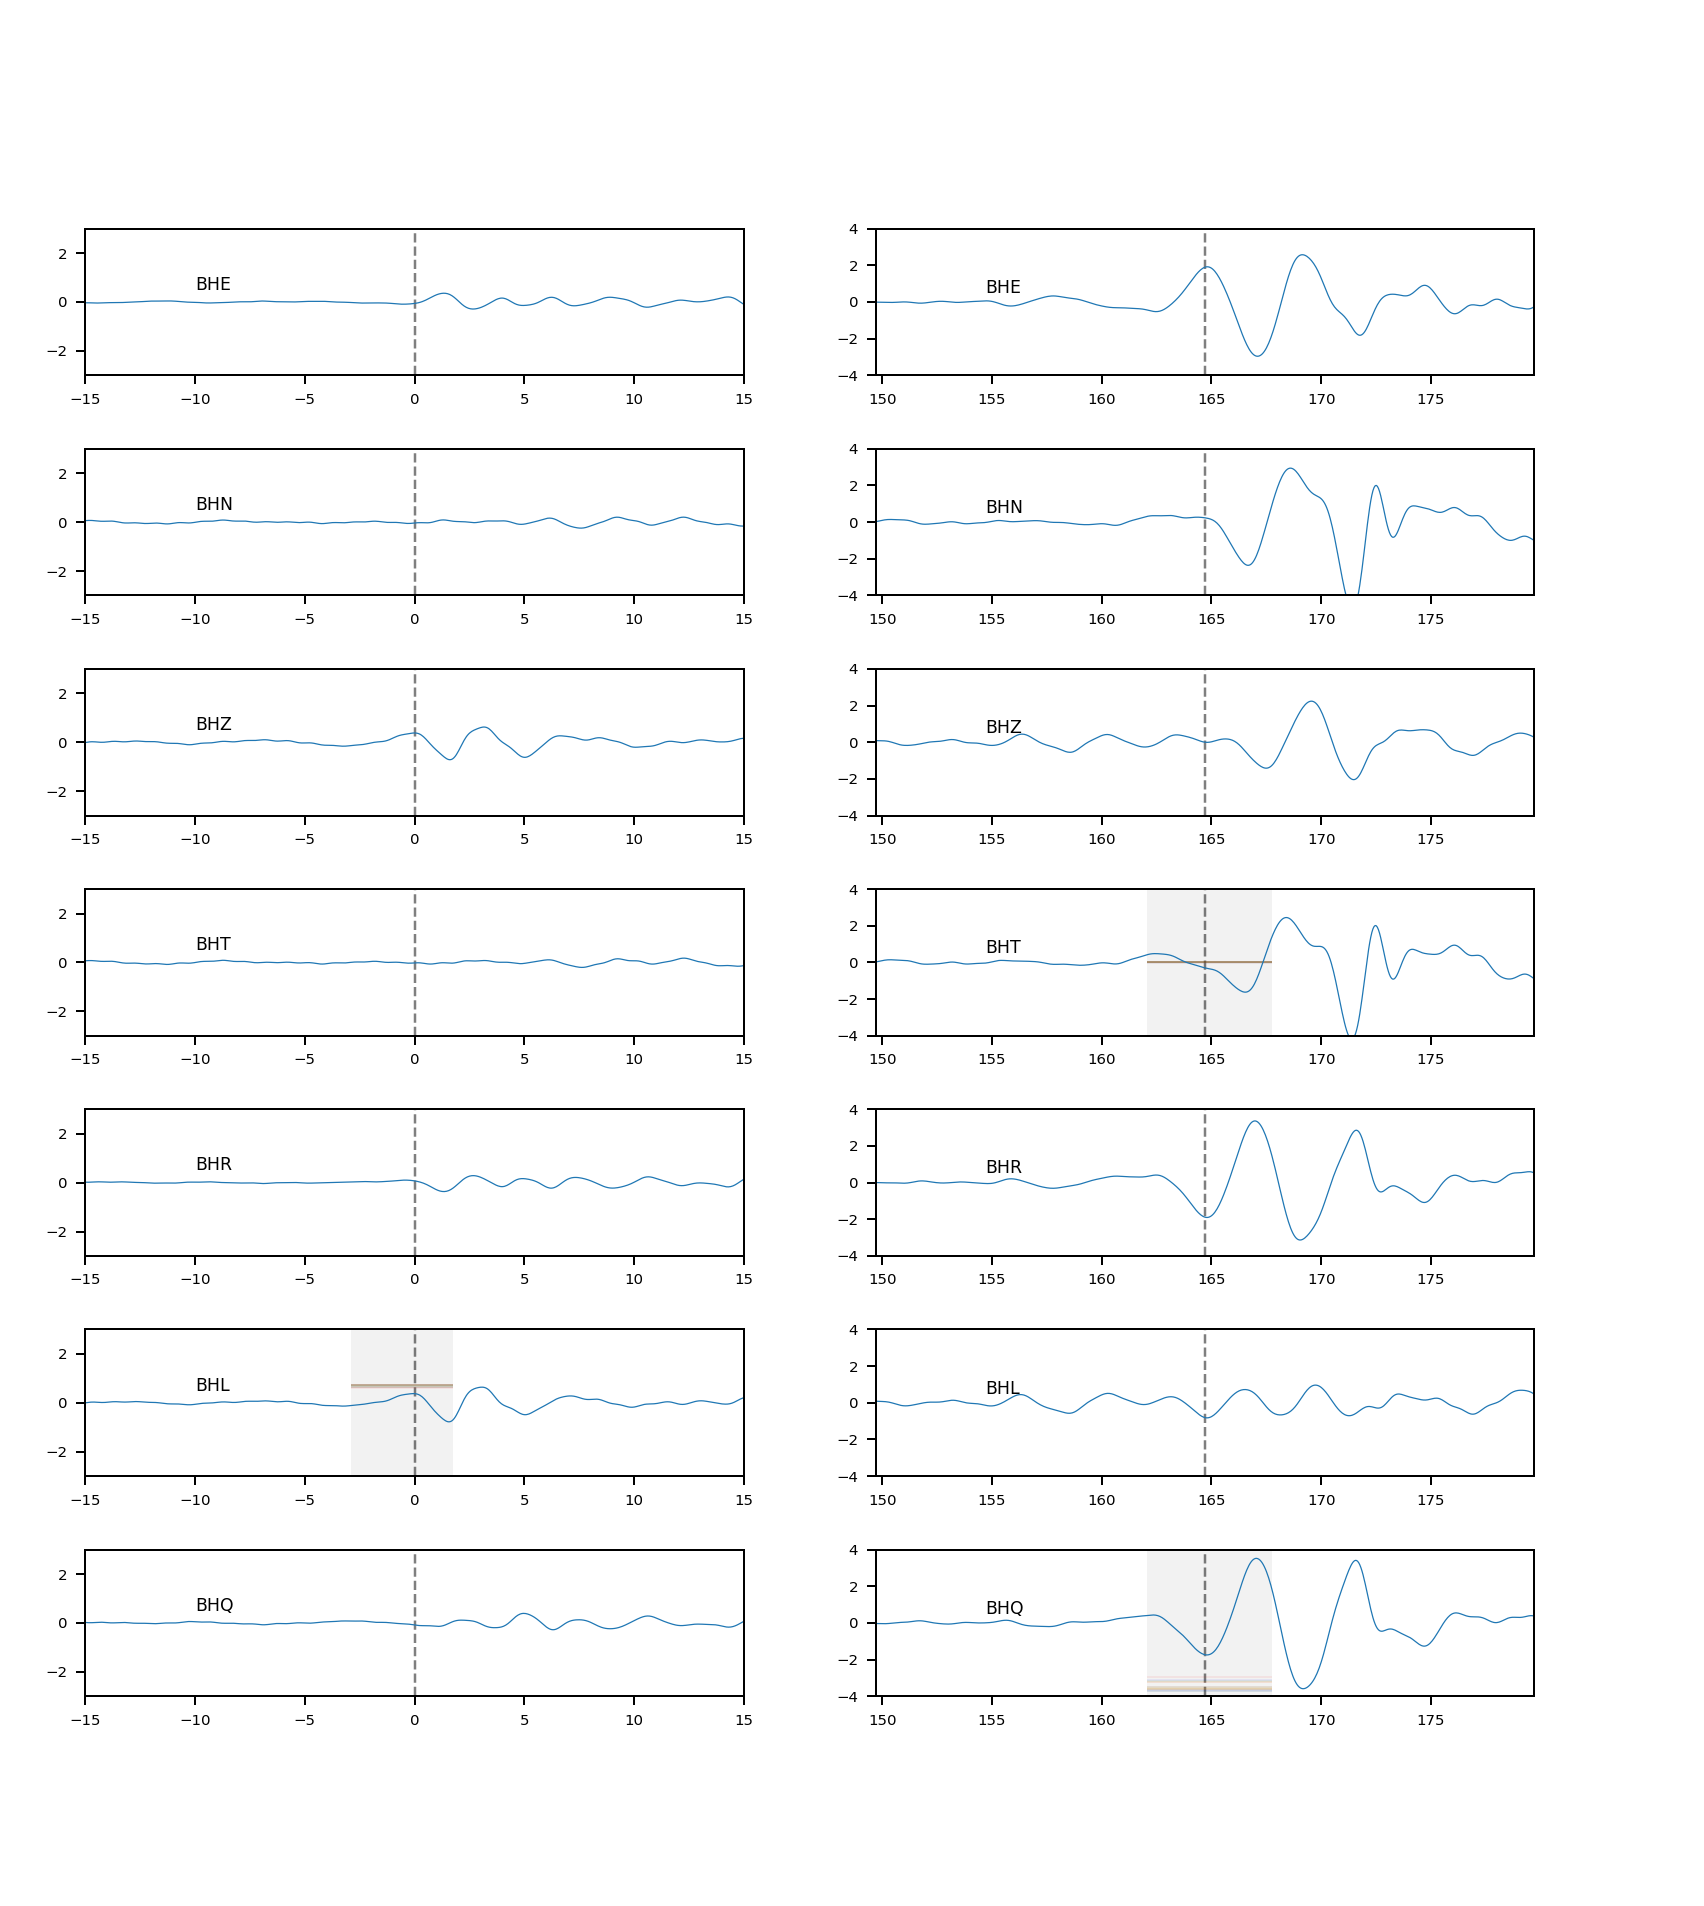

In [40]:
fig, axs = plt.subplots(7, 2, figsize=(5,10))

for j in range(7):
    axs[j][0].tick_params(labelsize=6)
    axs[j][1].tick_params(labelsize=6)

plt.subplots_adjust(left=0.05,hspace=0.5)

<IPython.core.display.Javascript object>


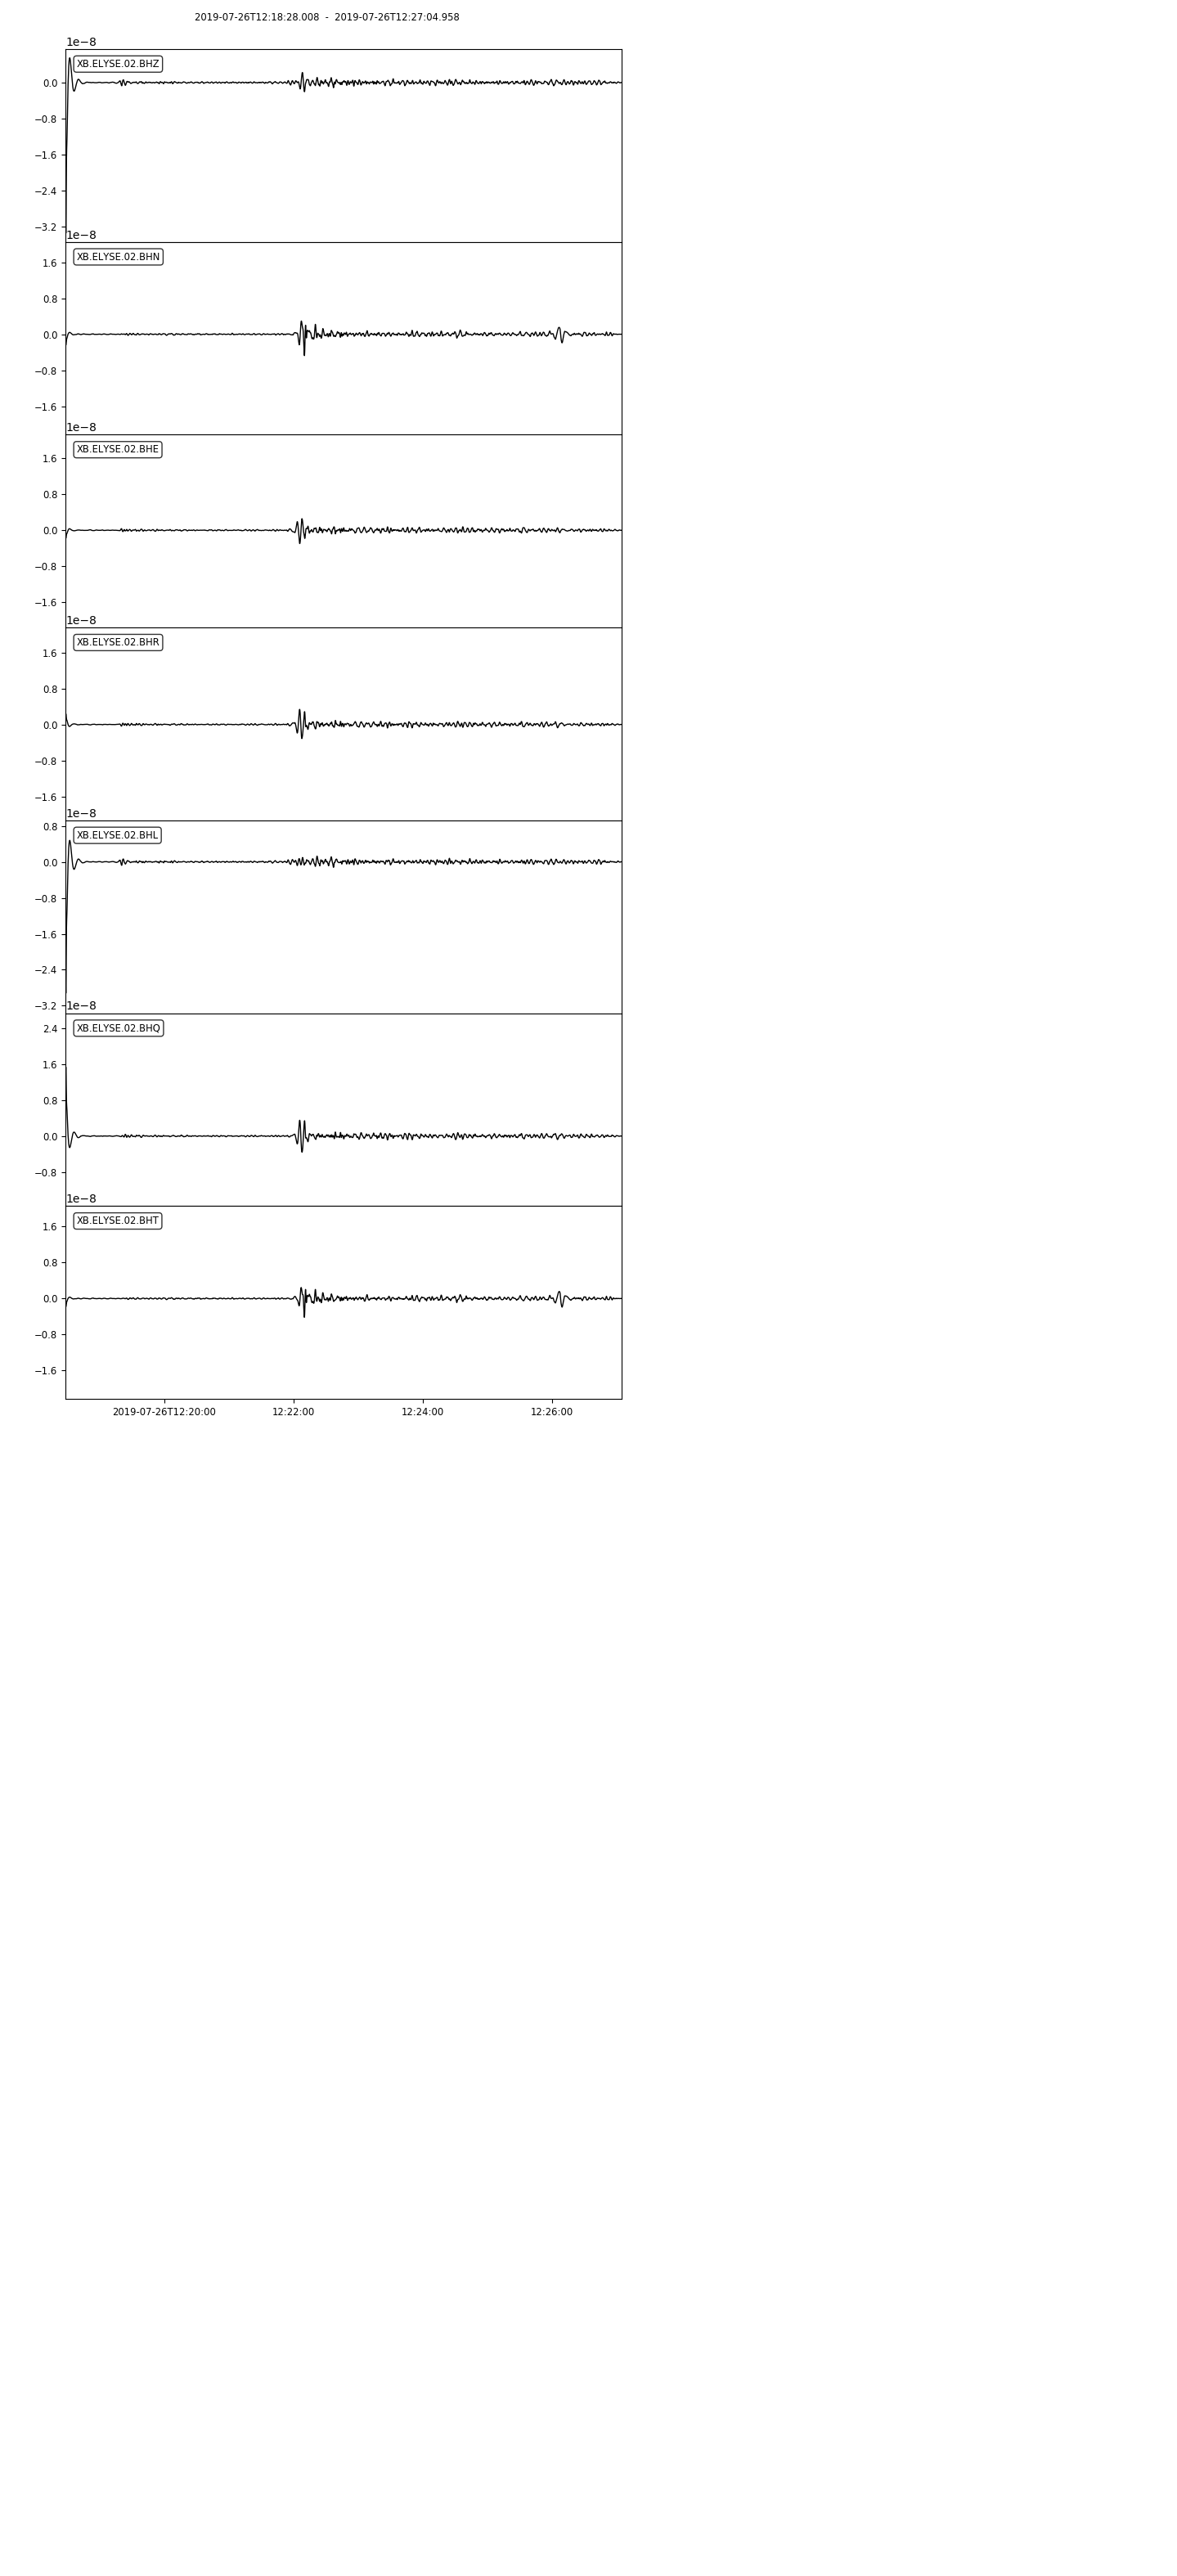

-2.9 1.75
162.08 167.75


In [42]:
P235b = UTCDateTime('2019-07-26T12:19:18')  # p-wave arrival
S235b = UTCDateTime('2019-07-26T12:22:05')    # s-wave arrival

Pt = UTCDateTime('2019-07-26T12:19:18.7')  # p-wave arrival
St = UTCDateTime('2019-07-26T12:22:03.38')    # s-wave arrival

Pst = UTCDateTime('2019-07-26T12:19:15.80')
Pend = UTCDateTime('2019-07-26T12:19:20.45')
Sst = UTCDateTime('2019-07-26T12:22:00.78')
Send = UTCDateTime('2019-07-26T12:22:06.45')

begin = P235b
end = S235b + 200

ang_235b = [254,25.5,23.2]

st_uvw = waveforms(begin, end, 100)
wfplot('S0235b',axs,st_uvw,ang_235b,0,164.7,Ptime=Pt)
timepatch(axs,Pt,Pst,Pend,St,Sst,Send,s0235b_amps)

In [10]:
def plotamps(ax,df):
    for index,row in df.iterrows():
        if df['Model'][index] == 'NewGudkova':
            c = 'blue'
        elif df['Model'][index] == 'TAYAK':
            c = 'orange'
        elif df['Model'][index] == 'MAAK':
            c = 'red'
        elif df['Model'][index] == 'Combined':
            c = 'green'
        print(c)
        #ax[5][0].hlines(df['P'],-2,2,lw=0.01,color=c,label=str(df['Depth']))
        #ax[6][1].hlines(df['SV'],-2,2,lw=0.01,color=c,label=str(df['Depth']))
        #ax[3][1].hlines(df['SH'],-2,2,lw=0.01,color=c,label=str(df['Depth']))
    
print(s0235b_amps['Model'])
plotamps(axs,s0235b_amps)


0     NewGudkova
1     NewGudkova
2     NewGudkova
3          TAYAK
4          TAYAK
5          TAYAK
6          TAYAK
7           MAAK
8           MAAK
9           MAAK
10          MAAK
11      Combined
12      Combined
13      Combined
14      Combined
Name: Model, dtype: object
blue
blue
blue
orange
orange
orange
orange
red
red
red
red
green
green
green
green


## S0325ab

<IPython.core.display.Javascript object>


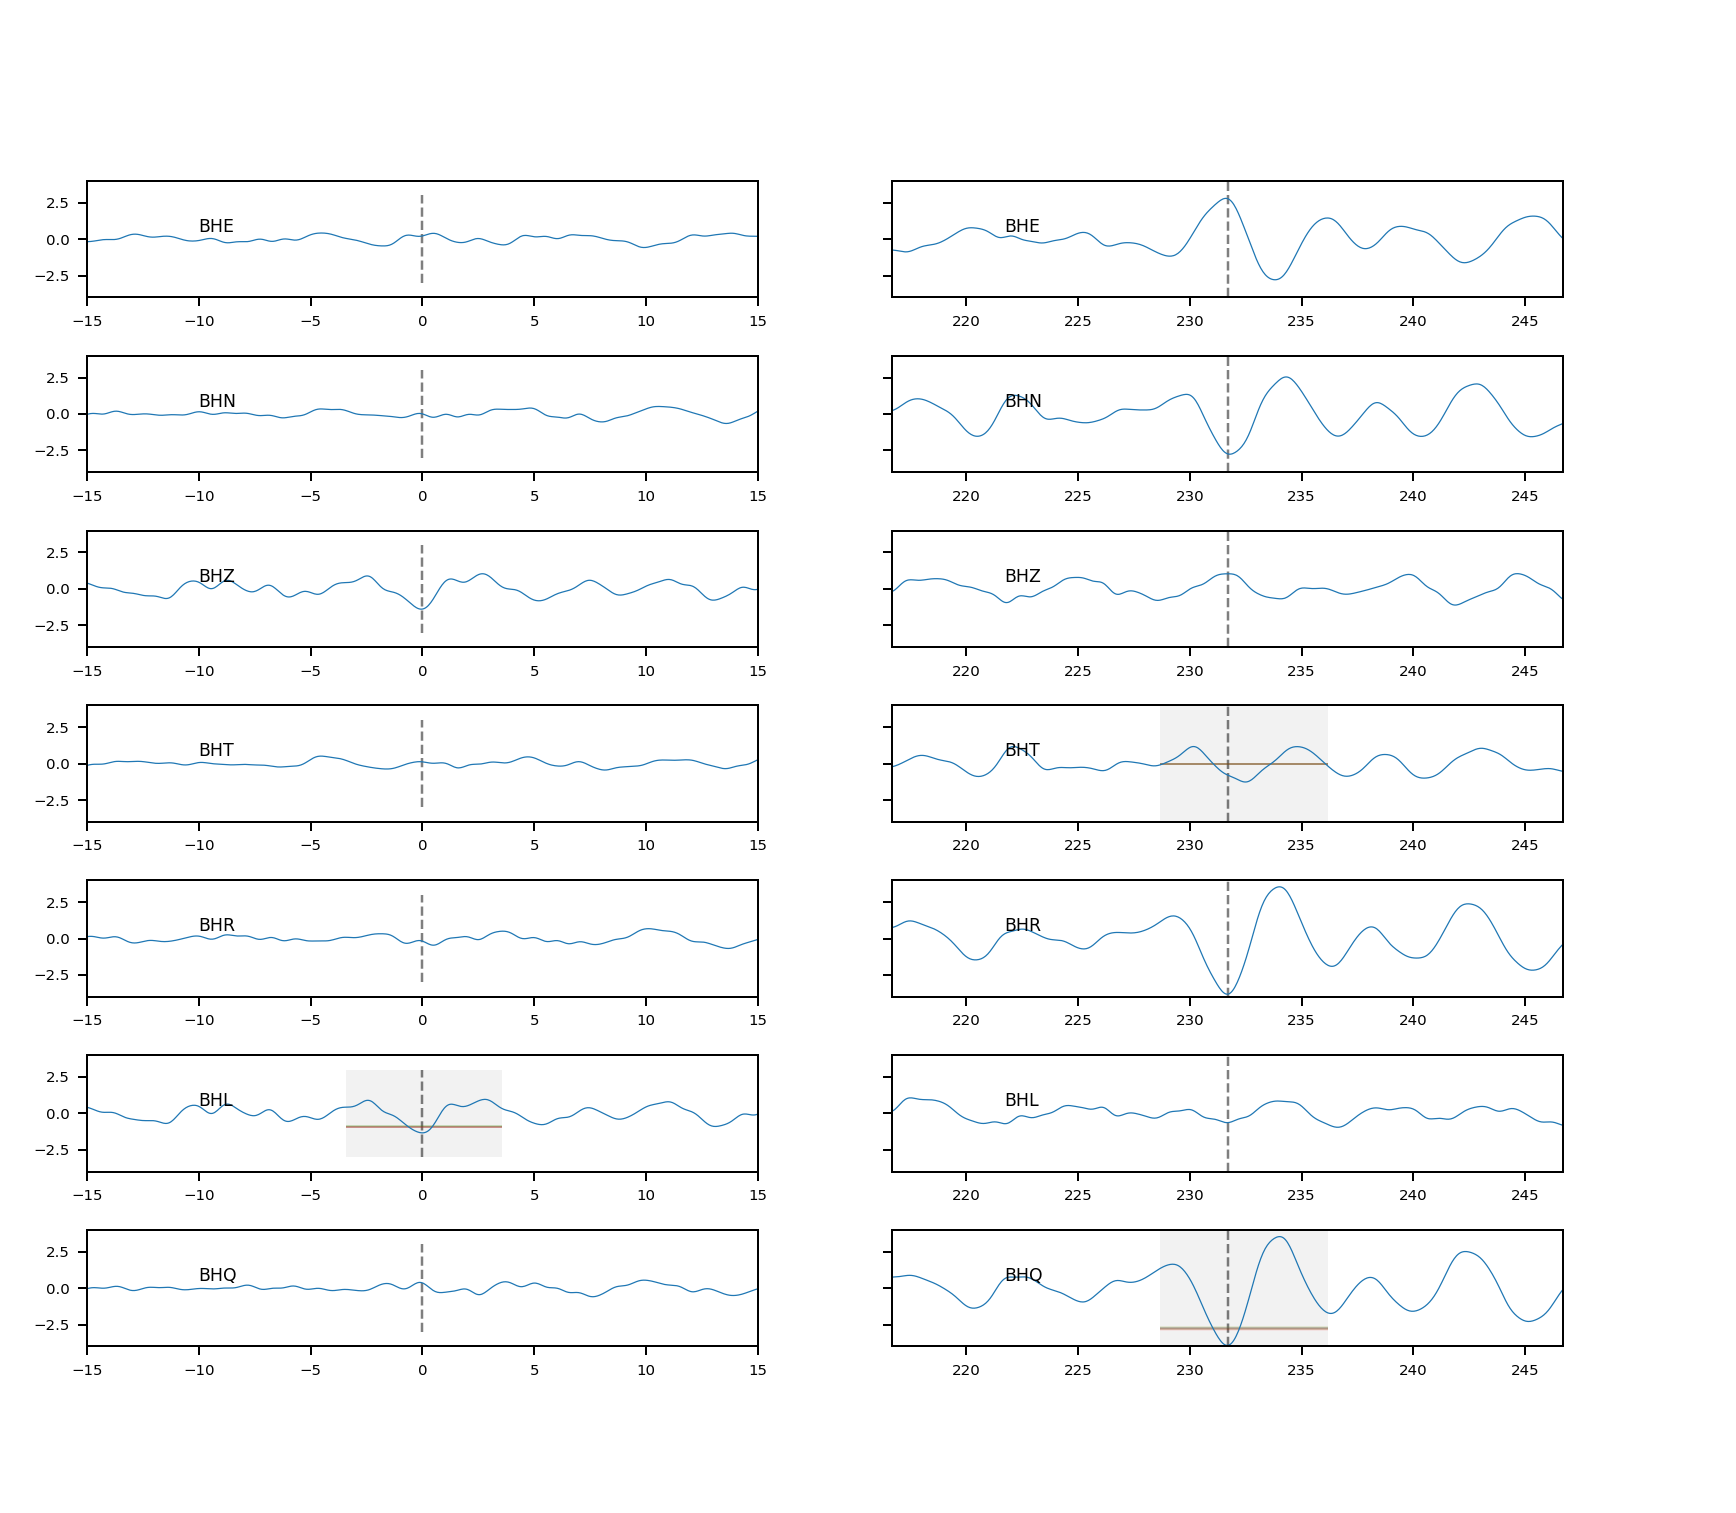

In [33]:
fig, azs = plt.subplots(7, 2, sharey=True, figsize=(7,7))

for j in range(7):
    azs[j][0].tick_params(labelsize=6)
    azs[j][1].tick_params(labelsize=6)

plt.subplots_adjust(left=0.05,hspace=0.5)

<IPython.core.display.Javascript object>


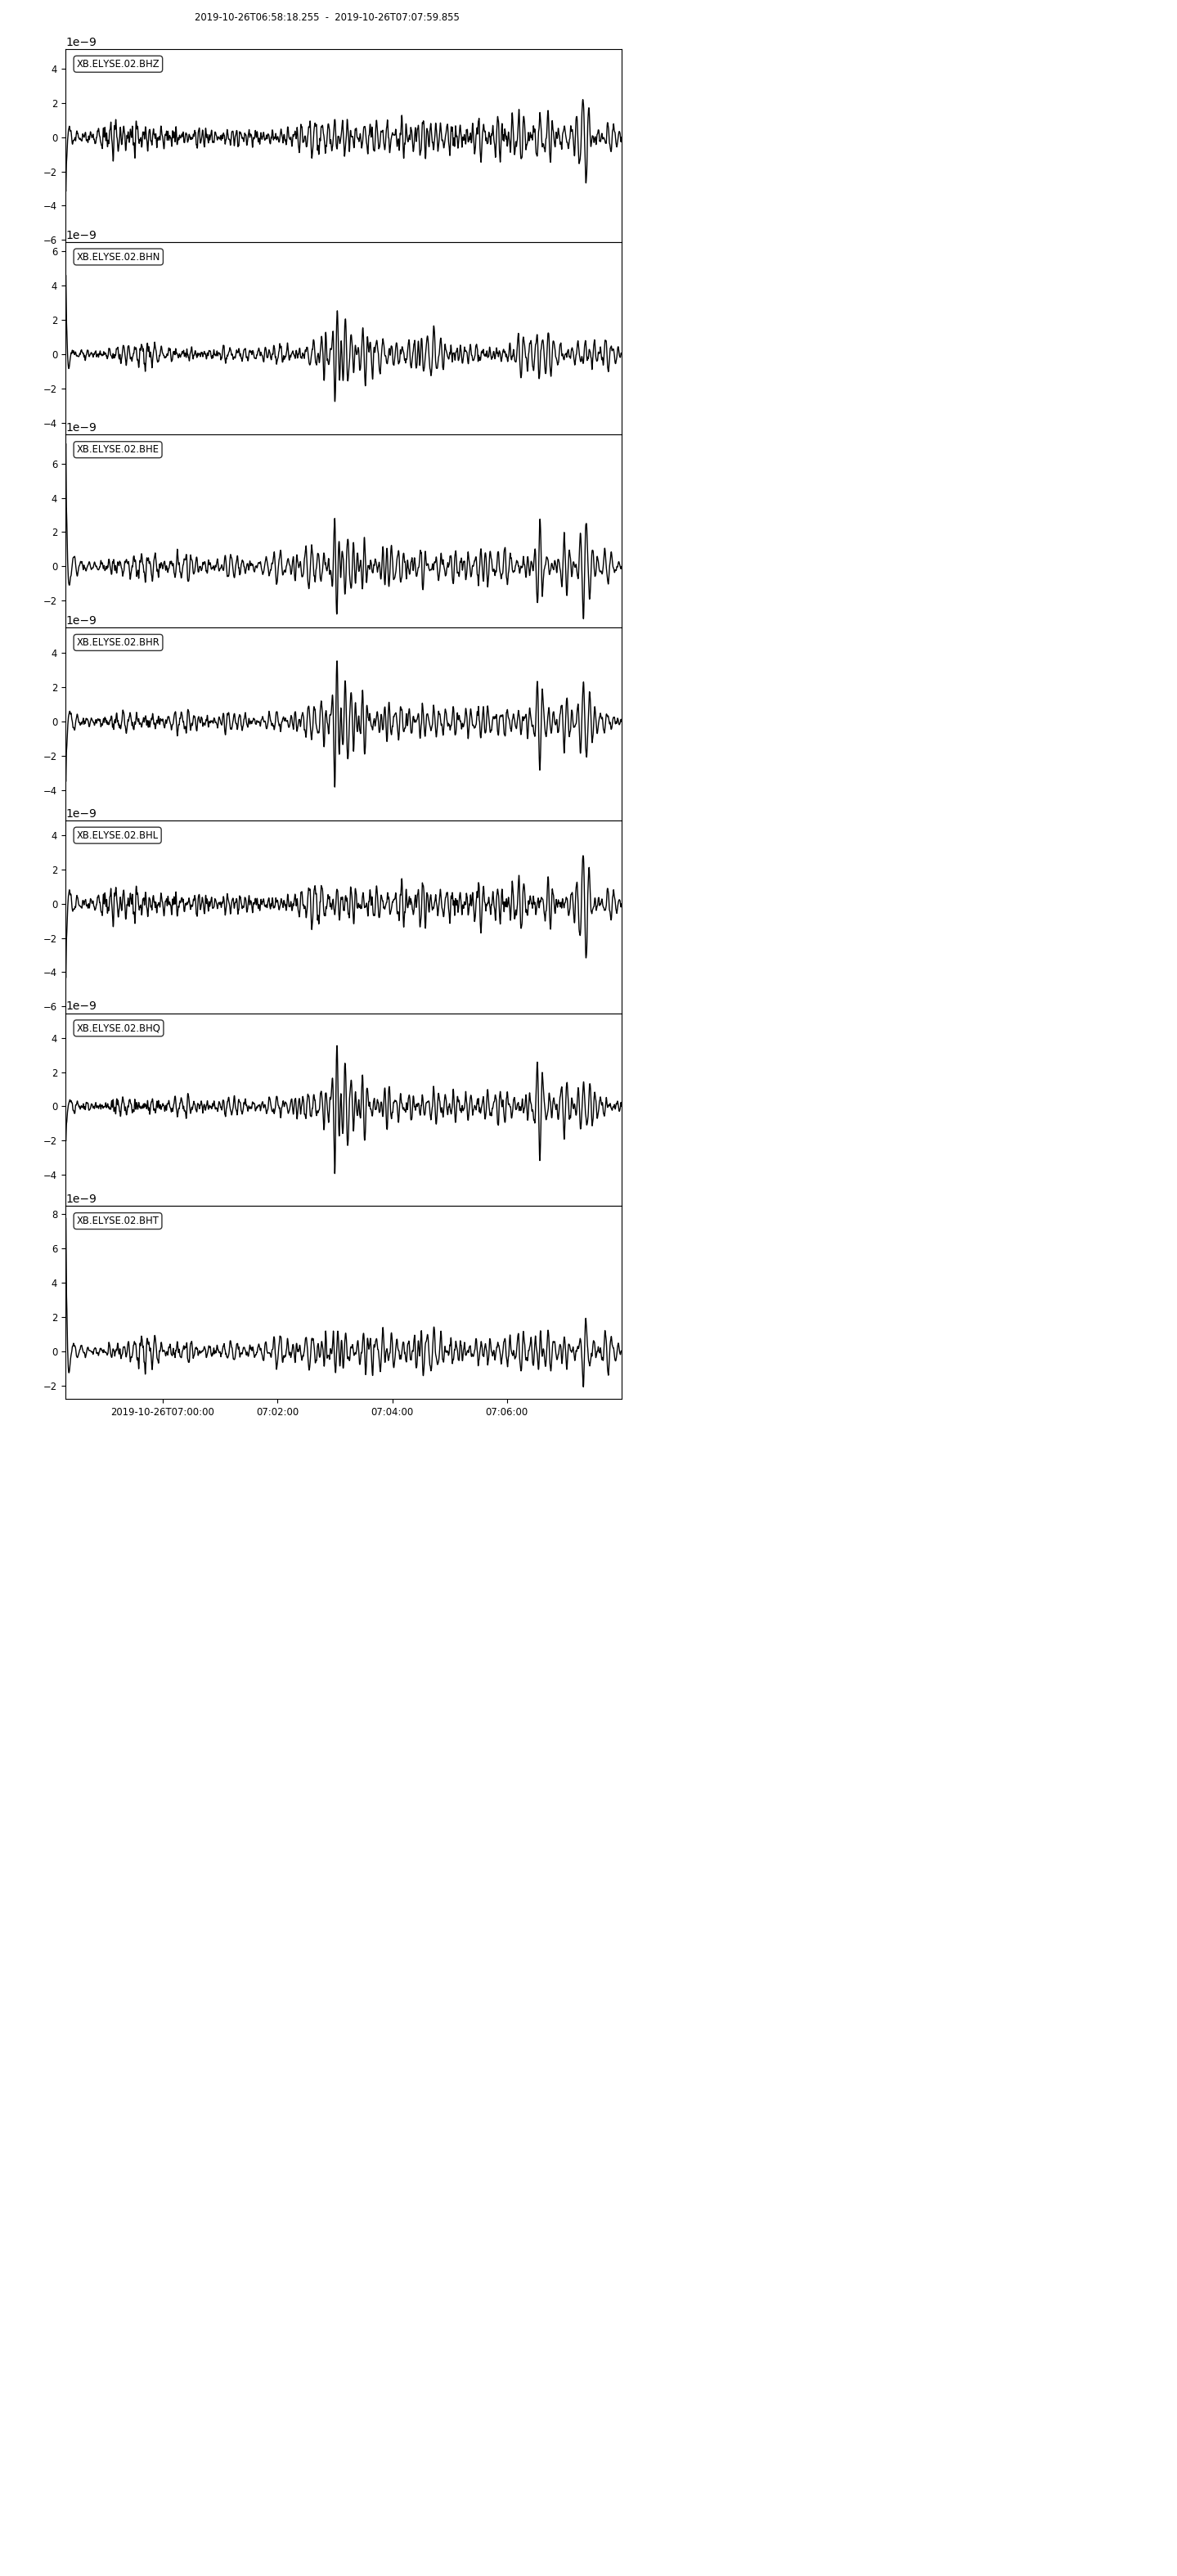

-3.43 3.57
228.65 236.19


In [35]:
#P325a = UTCDateTime('2019-10-26T06:58:57')  # p-wave arrival
#S325a = UTCDateTime('2019-10-26T07:02:46')    # s-wave arrival

Pt = UTCDateTime('2019-10-26T06:59:08.23')  # p-wave arrival
St = UTCDateTime('2019-10-26T07:02:59.9')  # s-wave arrival

Pst = UTCDateTime('2019-10-26T06:59:04.8')
Pend = UTCDateTime('2019-10-26T06:59:11.8')

Sst = UTCDateTime('2019-10-26T07:02:56.88')
Send = UTCDateTime('2019-10-26T07:03:04.42')

begin = Pt
end = St + 200

ang_325a = [303,24.4,22.4]

st_uvw = waveforms(begin, end, 100)
wfplot('S0325a',azs,st_uvw,ang_325a,0,231.7,Ptime=Pt)
timepatch(azs,Pt,Pst,Pend,St,Sst,Send,s0325ab_amps)

## 173a

<IPython.core.display.Javascript object>


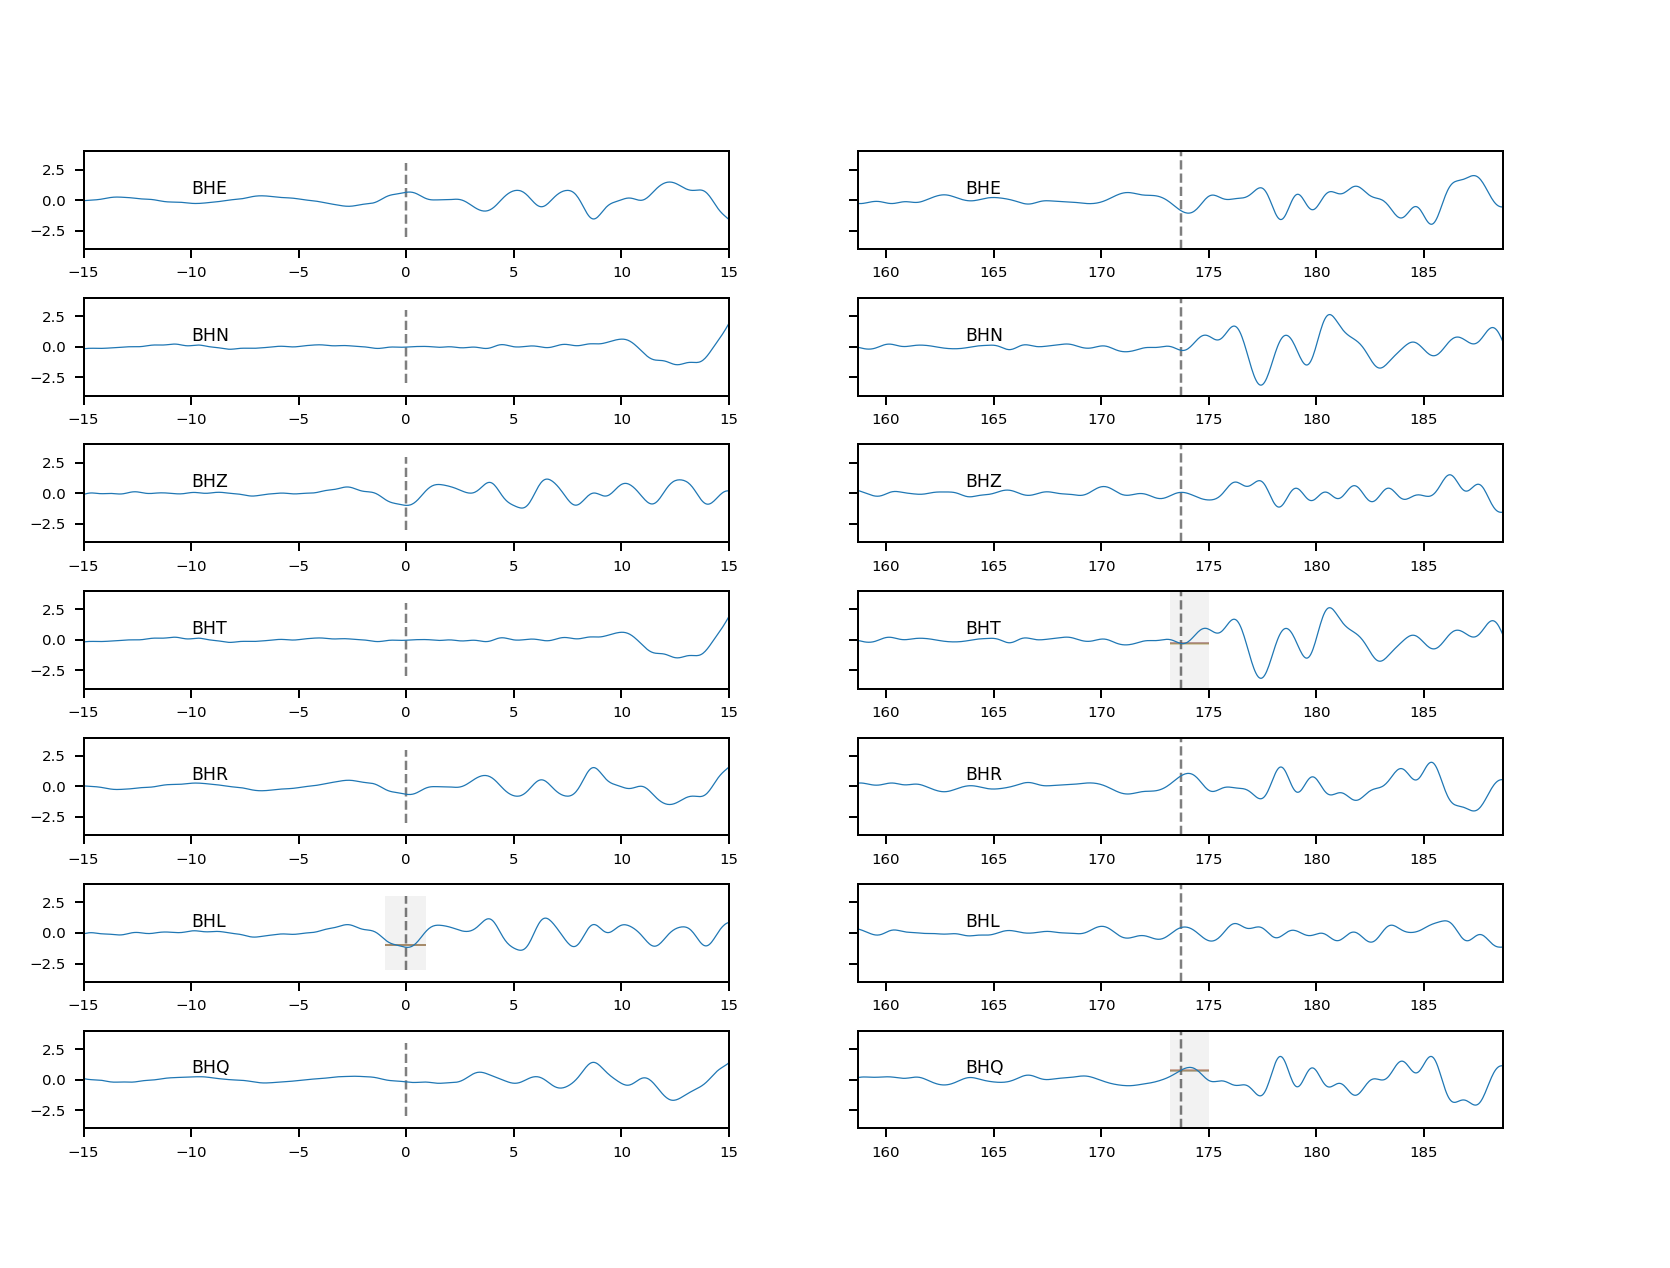

In [38]:
fig, ays = plt.subplots(7, 2, sharey=True, figsize=(7,7))

for j in range(7):
    ays[j][0].tick_params(labelsize=6)
    ays[j][1].tick_params(labelsize=6)

plt.subplots_adjust(left=0.05,hspace=0.5)

<IPython.core.display.Javascript object>


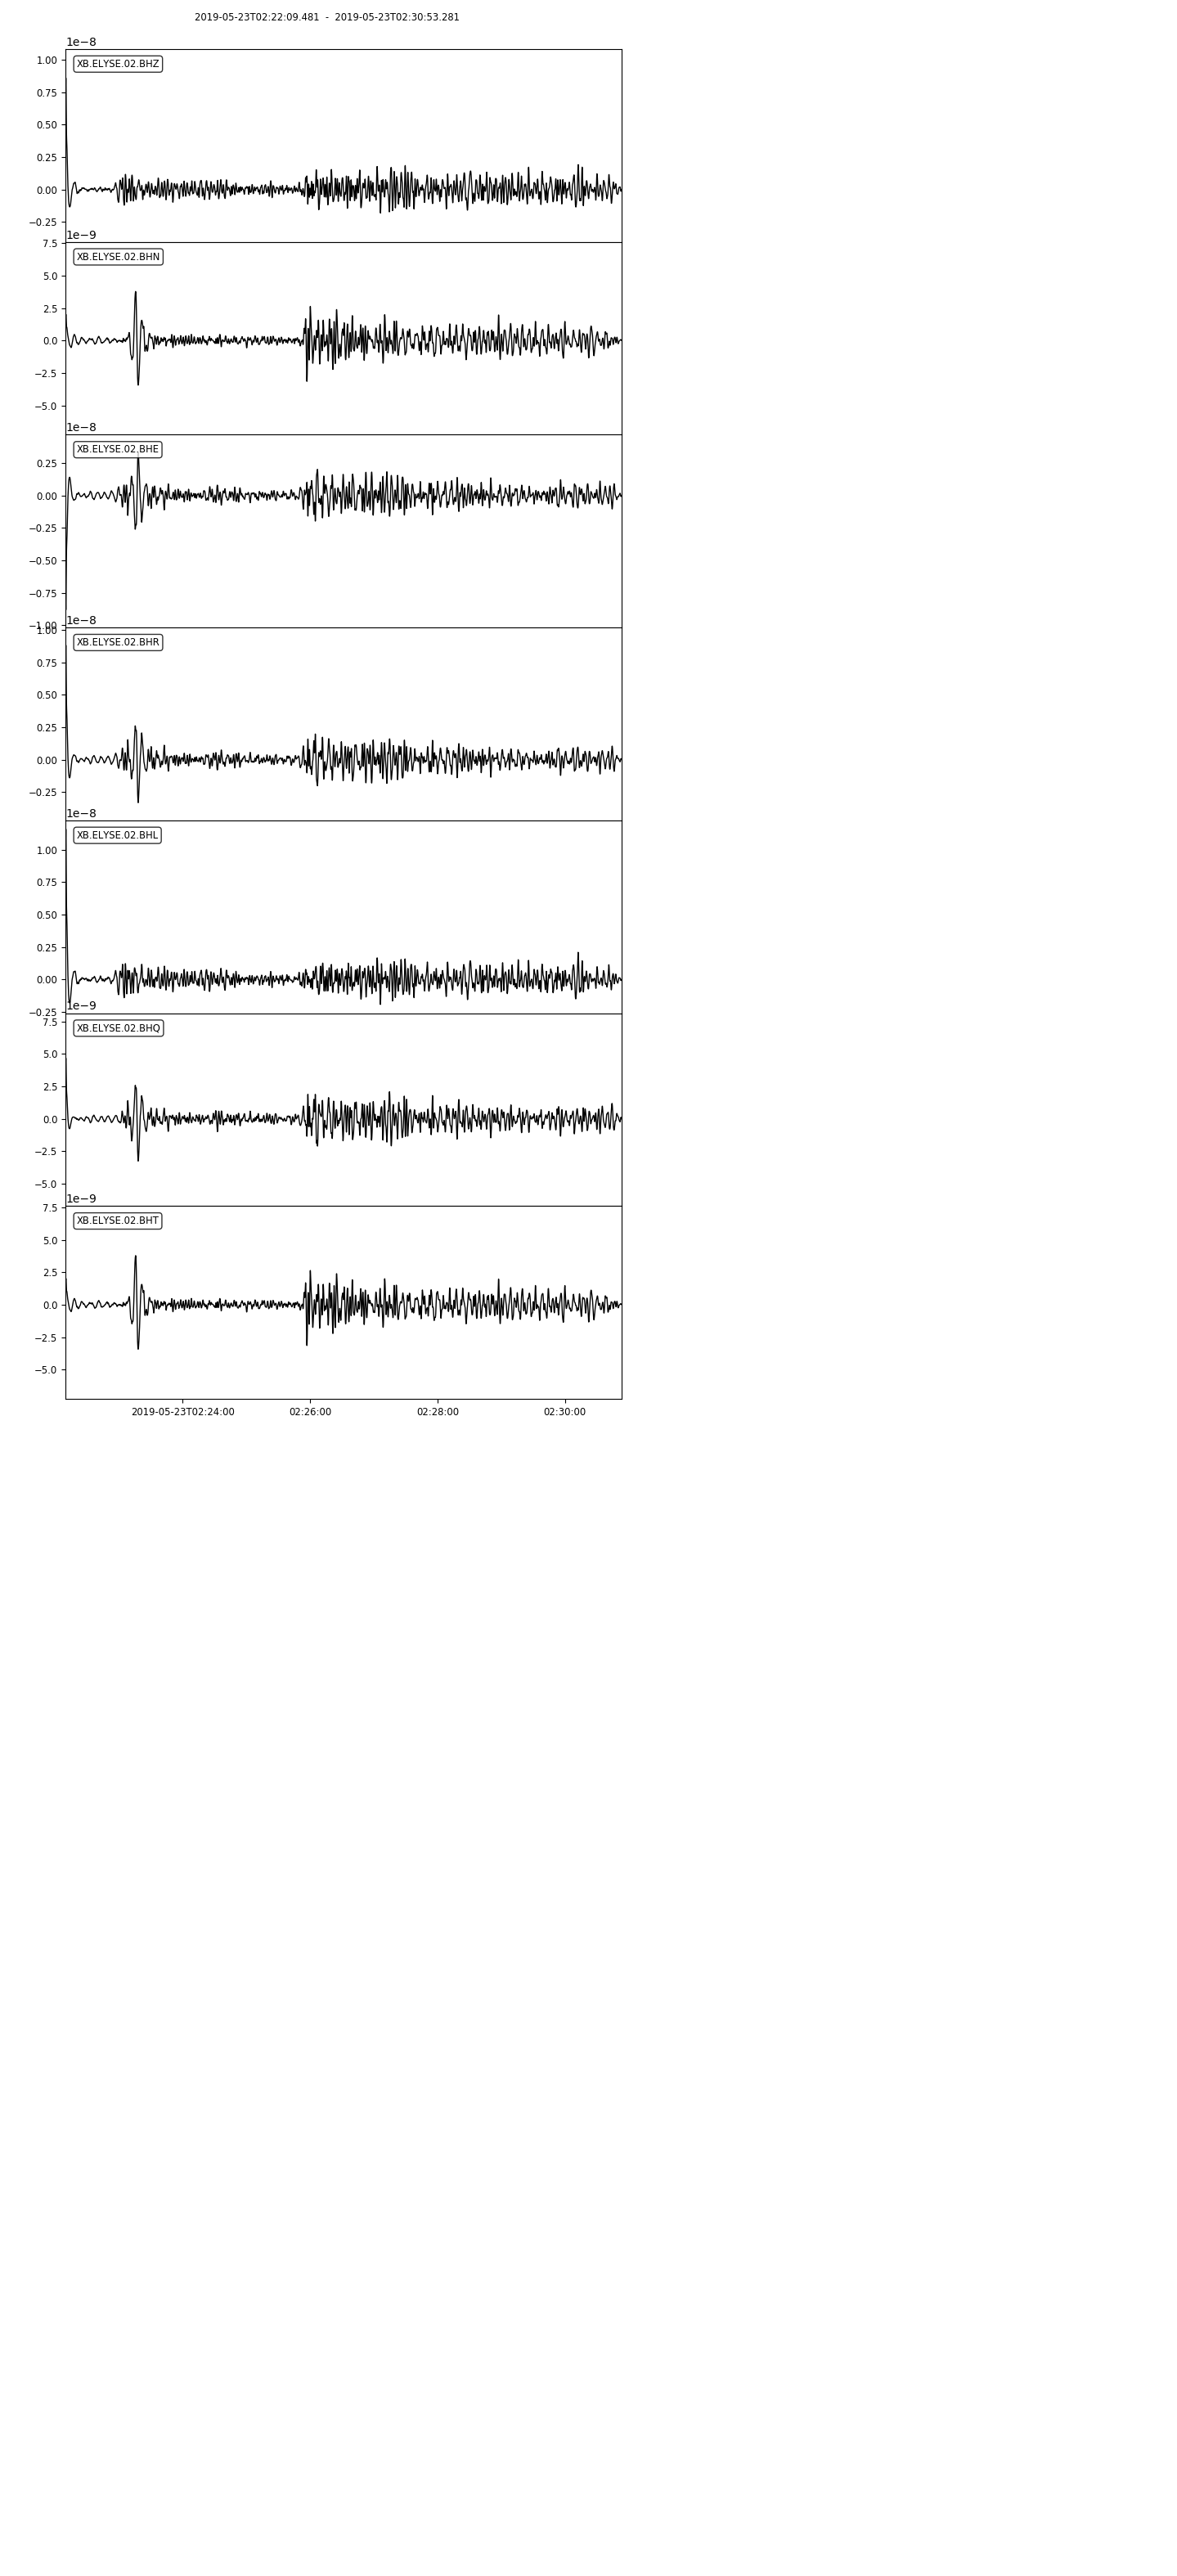

-1.0 0.94
173.21 175.01


In [39]:
Pt = UTCDateTime('2019-05-23T02:22:59.48')  # p-wave arrival
St = UTCDateTime('2019-05-23T02:25:53.3')  # s-wave arrival

Pst = UTCDateTime('2019-05-23T02:22:58.48')
Pend = UTCDateTime('2019-05-23T02:23:00.42')

Sst = UTCDateTime('2019-05-23T02:25:52.69')
Send = UTCDateTime('2019-05-23T02:25:54.49')

begin = Pt
end = St + 200

ang_173a = [270,25.9,23.4]

st_uvw = waveforms(begin, end, 100)
wfplot('S0173a',ays,st_uvw,ang_173a,0,173.7,Ptime=Pt)
timepatch(ays,Pt,Pst,Pend,St,Sst,Send,s0173a_amps)

## 173ab

<IPython.core.display.Javascript object>


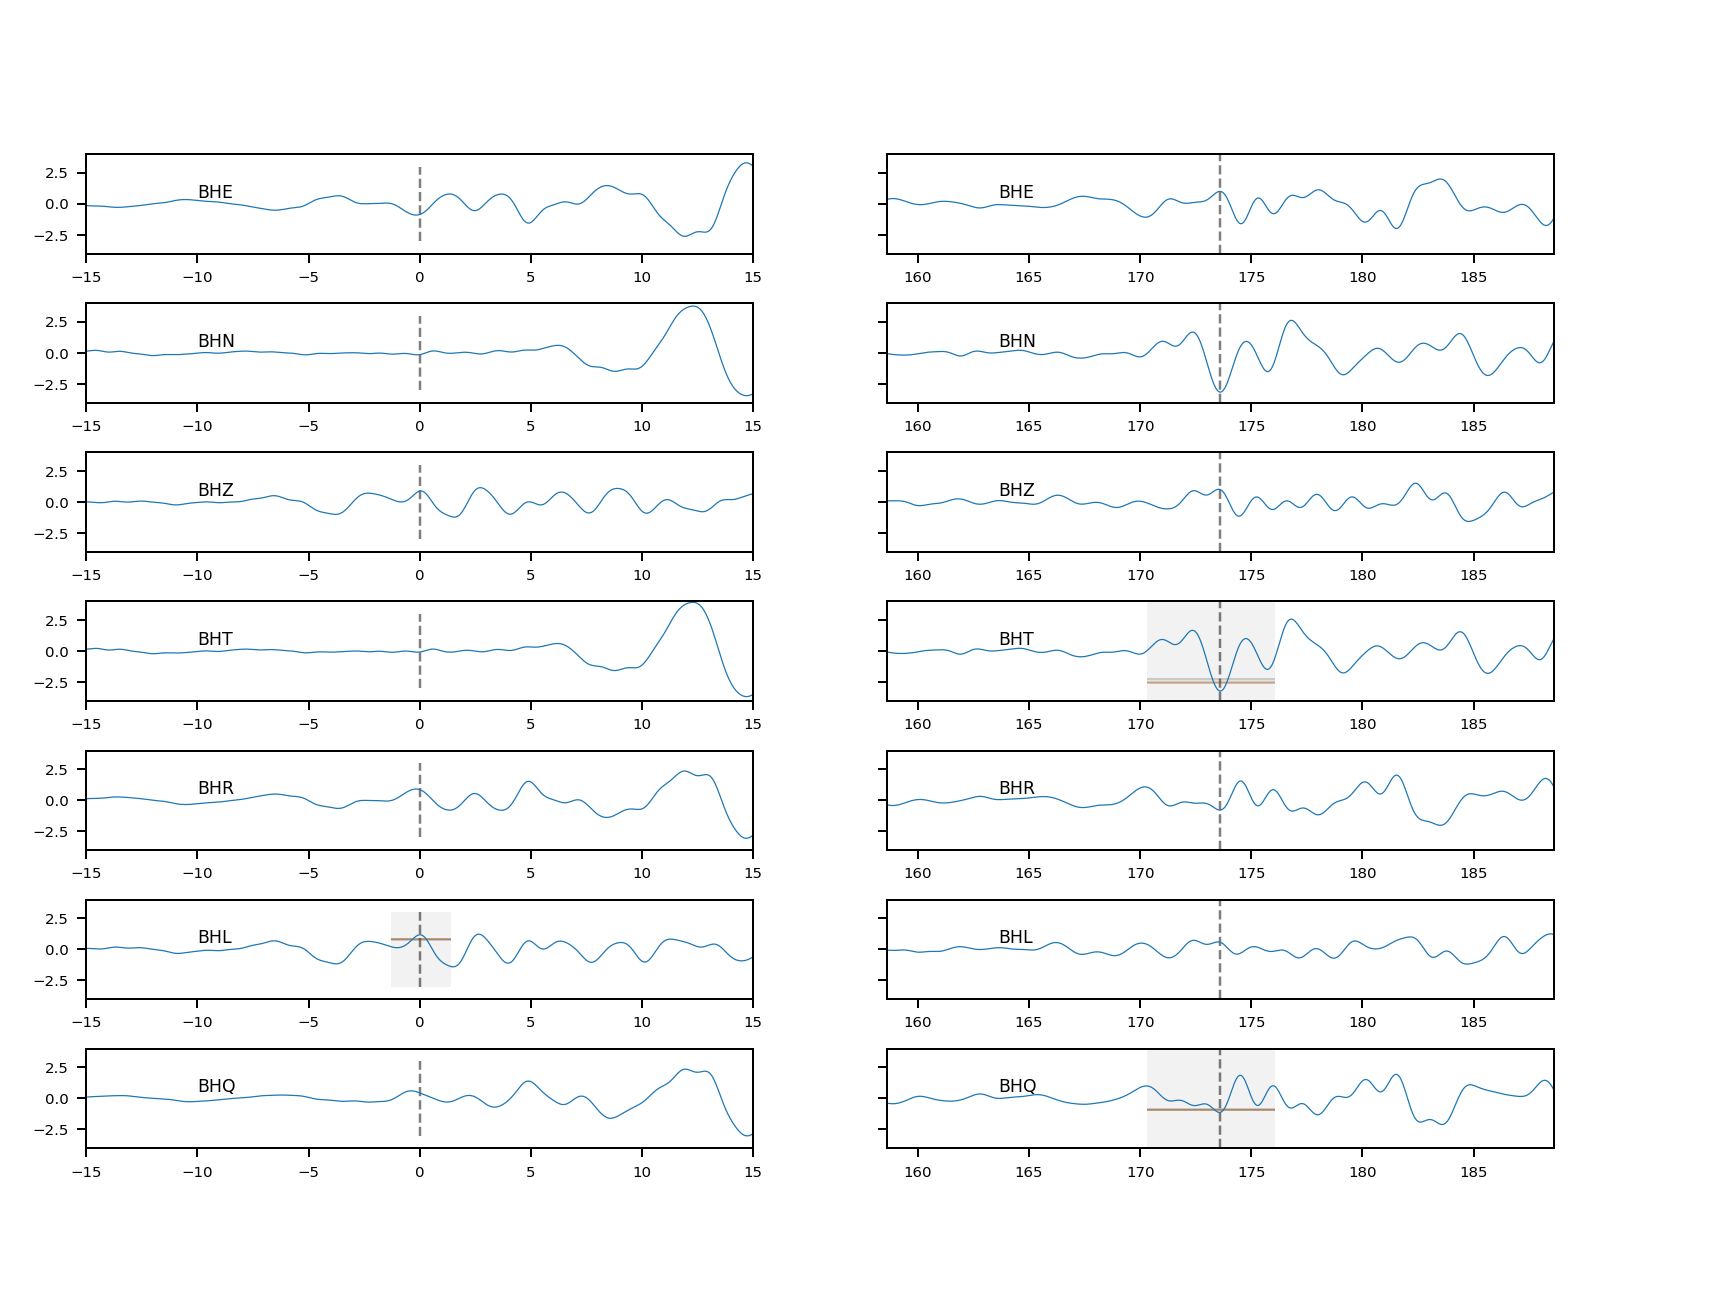

In [36]:
fig, aws = plt.subplots(7, 2, sharey=True, figsize=(7,7))

for j in range(7):
    aws[j][0].tick_params(labelsize=6)
    aws[j][1].tick_params(labelsize=6)

plt.subplots_adjust(left=0.05,hspace=0.5)

<IPython.core.display.Javascript object>


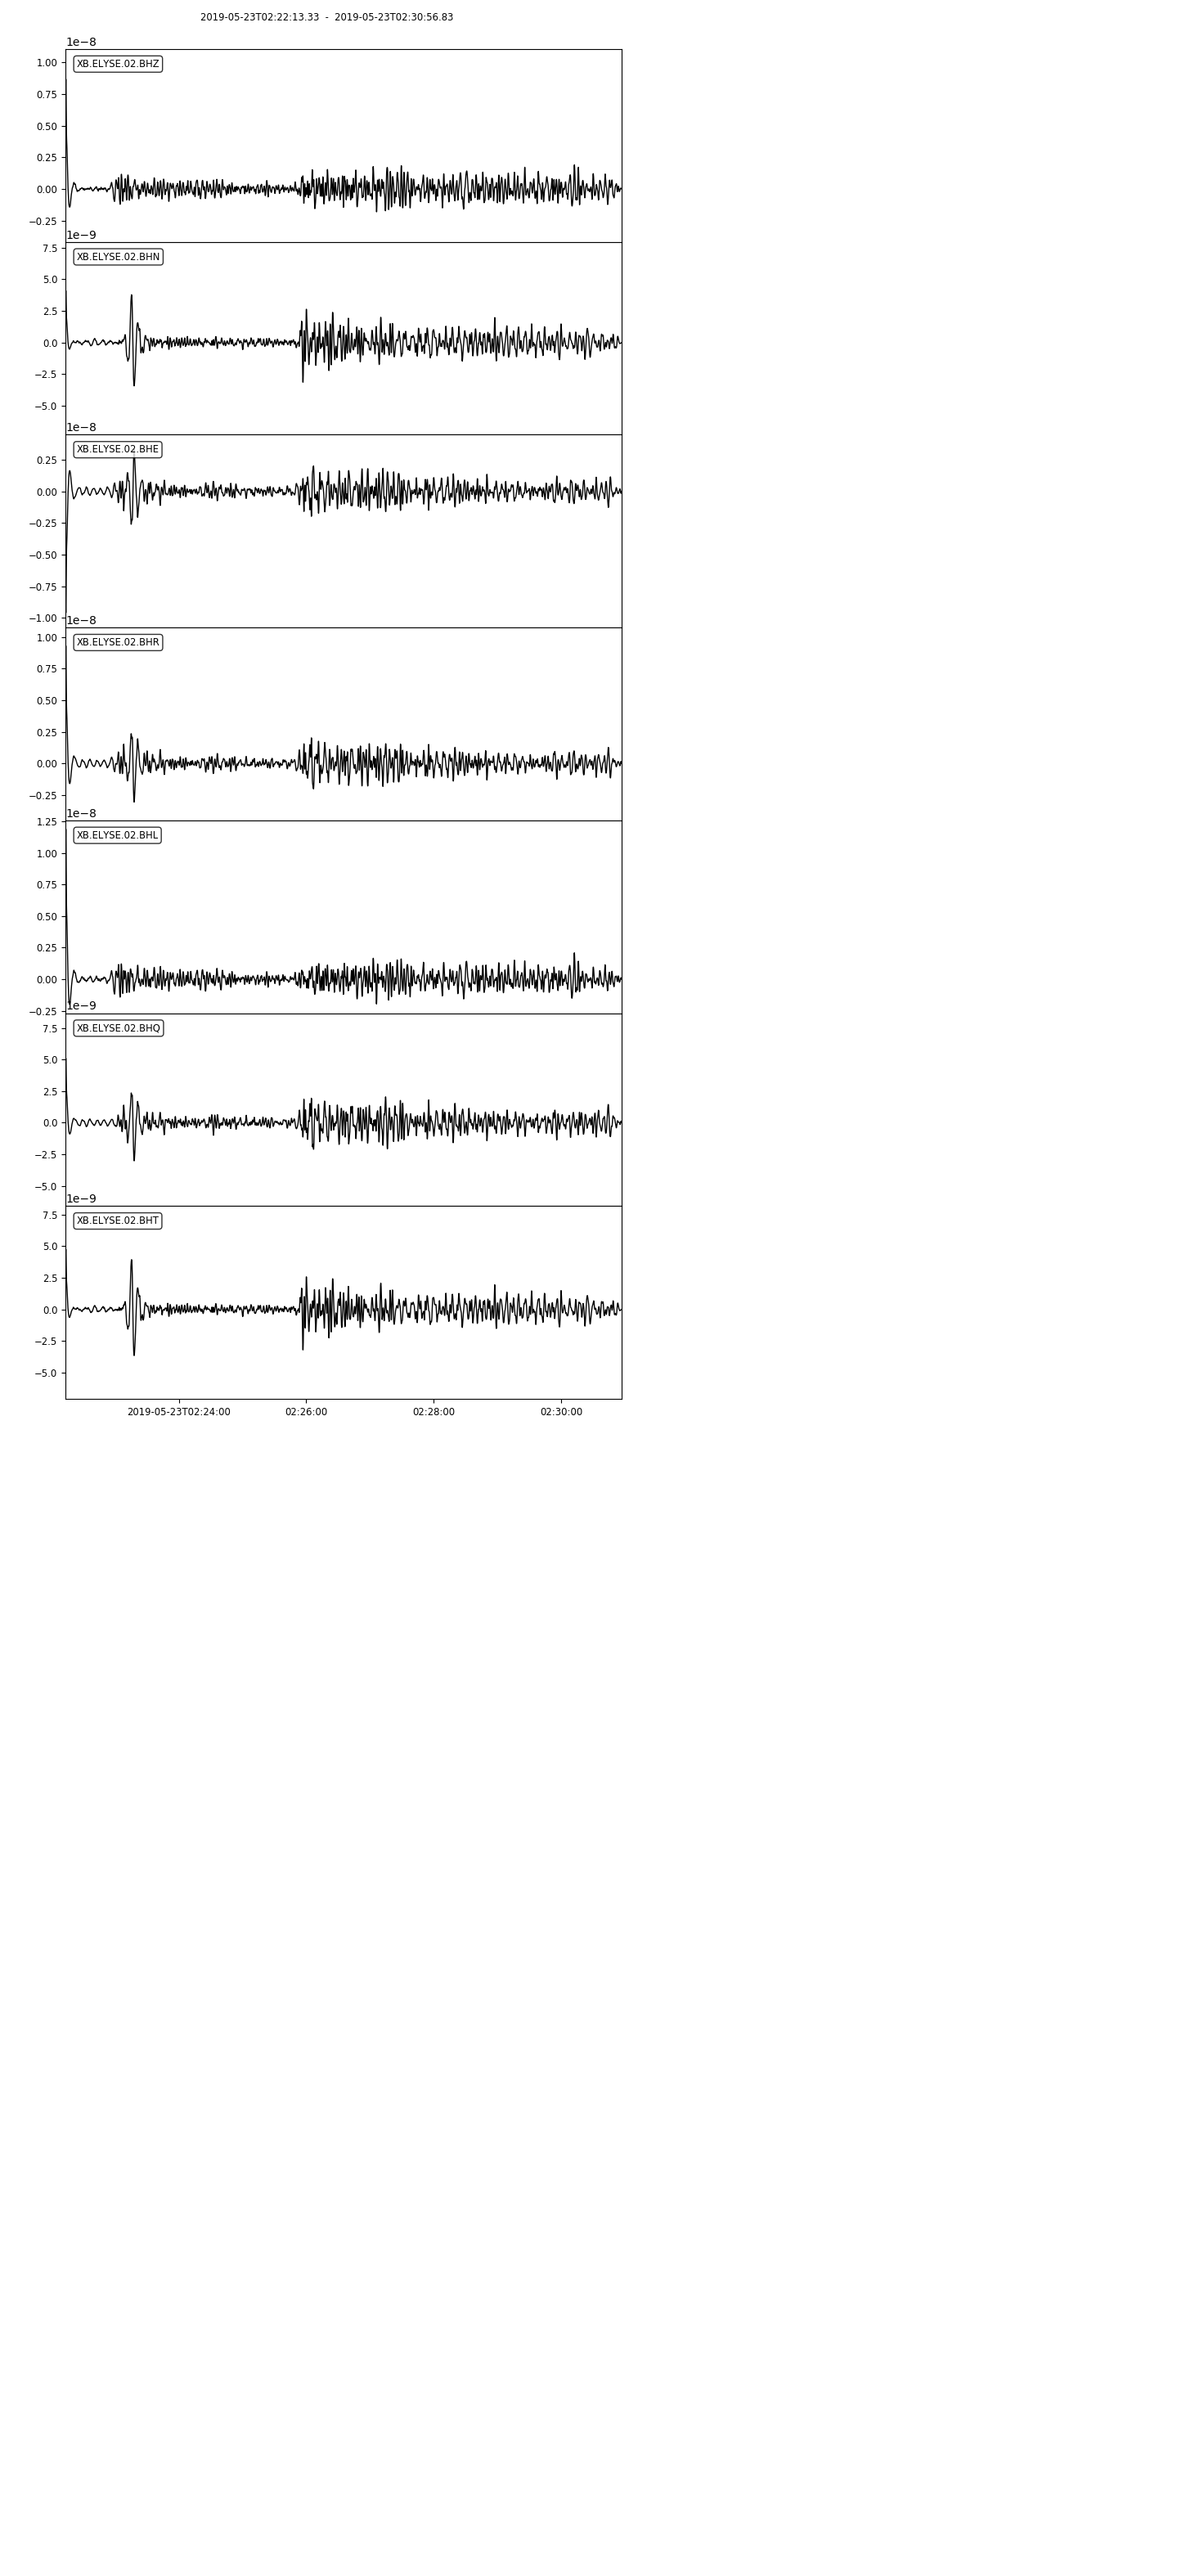

-1.29 1.4
170.33 176.09


In [37]:
P173ab = UTCDateTime('2019-05-23T02:23:03.3')  # p-wave arrival
S173ab = UTCDateTime('2019-05-23T02:25:56.87')    # s-wave arrival

Pt = UTCDateTime('2019-05-23T02:23:03.3')  # p-wave arrival
St = UTCDateTime('2019-05-23T02:25:56.87')  # s-wave arrival

Pst = UTCDateTime('2019-05-23T02:23:02.01')
Pend = UTCDateTime('2019-05-23T02:23:04.7')

Sst = UTCDateTime('2019-05-23T02:25:53.63')
Send = UTCDateTime('2019-05-23T02:25:59.39')

begin = P173ab
end = S173ab + 200

ang_173ab = [266,25.9,23.4]

st_uvw = waveforms(begin, end, 100)
wfplot('S0173ab',aws,st_uvw,ang_173ab,0,173.6,Ptime=Pt)
timepatch(aws,Pt,Pst,Pend,St,Sst,Send,s0173ab_amps)

# beachballs

In [51]:
def bbplot(file, event, alpha = 0.1):
    path = '/Users/maddysita/Desktop/CIERA_REU/script_notebooks/beachballs/csvs/'
    faults = pd.read_csv(path + str(file), usecols=[0,1,2])

    faults_ls =[]

    for index, rows in faults.iterrows():
        my_list =[rows.Strike, rows.Dip, rows.Rake]
        faults_ls.append(my_list)
    
    n = 0
    for fault in faults_ls:
        if n == 0:
            fig = beachball(fault, alpha = alpha, edgecolor = None)

        else:
            fig2 = beachball(fault, alpha = alpha, edgecolor = None, fig=fig)
        n += 1
        
    fig.patch.set_visible(False)
    #plt.savefig('mf3d_' + event + '.png')
    return

def sep_bbplot(data, event, alpha = 0.1):
    faults = data.loc[:,['Strike','Dip', 'Rake']]
    
    faults_ls = []
    
    for index, rows in faults.iterrows():
        my_list =[rows.Strike, rows.Dip, rows.Rake]
        faults_ls.append(my_list)
    
    n = 0
    for f in faults_ls:
        if n == 0:
            fig = beachball(f, alpha = alpha, edgecolor = None)

        else:
            fig2 = beachball(f, alpha=alpha, edgecolor = None, fig=fig)
        n += 1
    
    fig.patch.set_visible(False)
    fig.suptitle(event)
    #plt.savefig(event + '.png')
    return

path = '/Users/maddysita/Desktop/CIERA_REU/script_notebooks/beachballs/csvs/'

In [48]:
def model_bballs(df):
    df_NG = df[df['Model'] == 'NewGudkova']
    df_T = df[df['Model'] == 'TAYAK']
    df_M = df[df['Model'] == 'MAAK']
    df_C = df[df['Model'] == 'Combined']
    
    sep_bbplot(df_NG,'NewGudkova')
    sep_bbplot(df_T,'TAYAK')
    sep_bbplot(df_M, 'MAAK')
    sep_bbplot(df_C, 'Combined')

   ?       Model  Depth  Strike  Dip  Rake         P        SV        SH
0  0  NewGudkova     35      34   69   -36  0.624753 -3.134971 -0.000256
1  0  NewGudkova     45     166   49   -94  0.730532 -3.685525  0.004242
2  0  NewGudkova     55     172   49   -80  0.727999 -3.666030 -0.003826


<IPython.core.display.Javascript object>


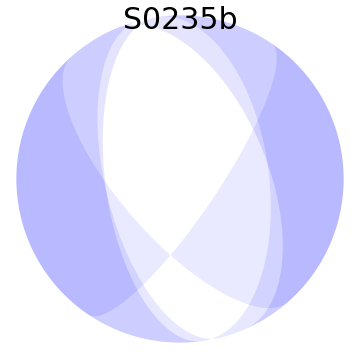

/anaconda3/envs/REU2020/lib/python3.7/site-packages/obspy/imaging/beachball.py:254: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111, aspect='equal')


In [52]:
df_NG = s0235b_amps[s0235b_amps['Model'] == 'NewGudkova']
df_T = s0235b_amps[s0235b_amps['Model'] == 'TAYAK']

print(df_NG)

sep_bbplot(df_NG,'S0235b')

## S0235b

<IPython.core.display.Javascript object>


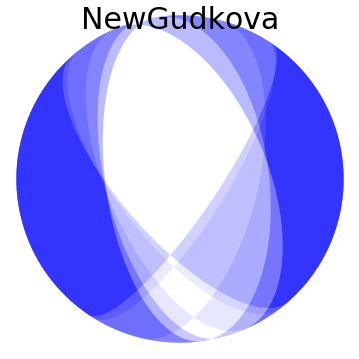

<IPython.core.display.Javascript object>


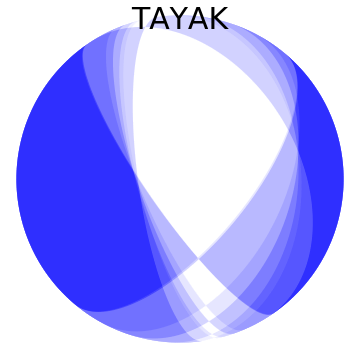

<IPython.core.display.Javascript object>


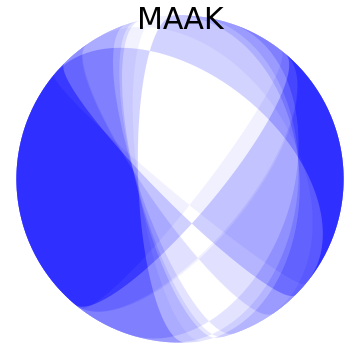

<IPython.core.display.Javascript object>


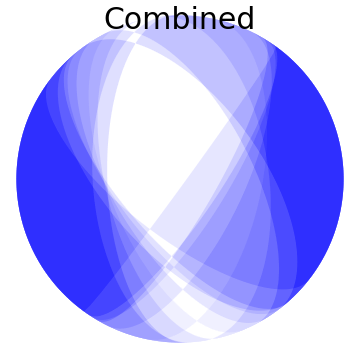

In [55]:
model_bballs(s0235b_amps_top3)

## S0173a

<IPython.core.display.Javascript object>


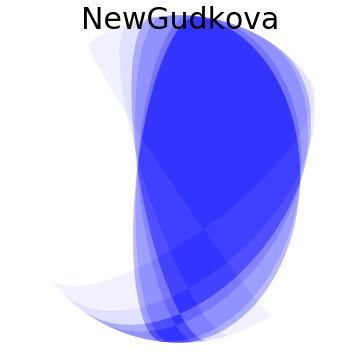

<IPython.core.display.Javascript object>


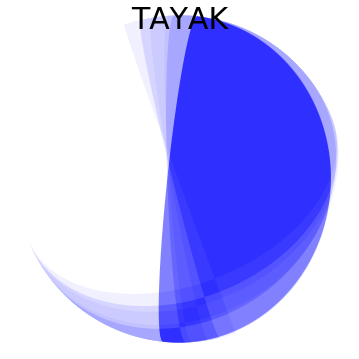

<IPython.core.display.Javascript object>


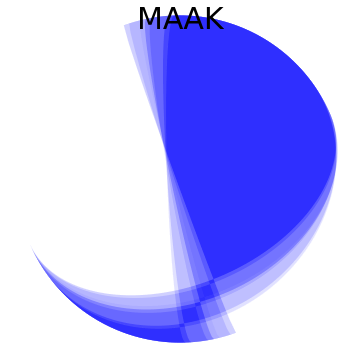

<IPython.core.display.Javascript object>


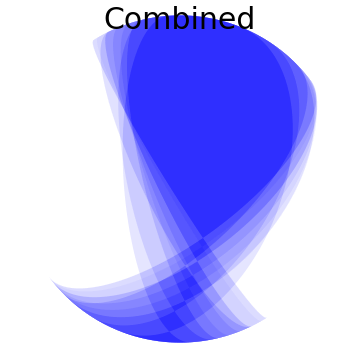

In [58]:
model_bballs(s0173a_amps_top3)

## S0173ab

<IPython.core.display.Javascript object>


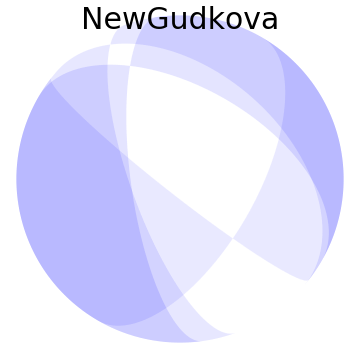

<IPython.core.display.Javascript object>


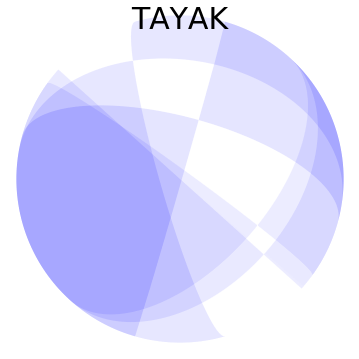

<IPython.core.display.Javascript object>


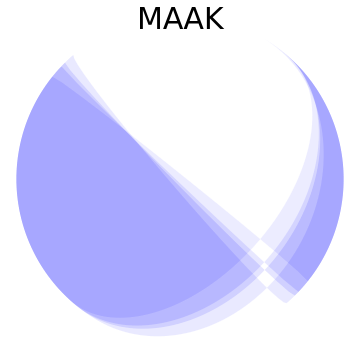

<IPython.core.display.Javascript object>


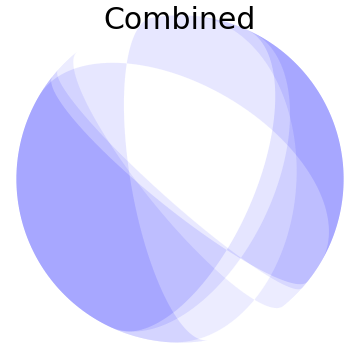

In [59]:
model_bballs(s0173ab_amps)

<IPython.core.display.Javascript object>


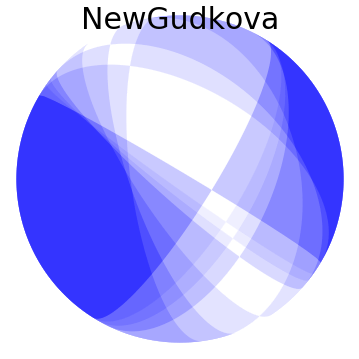

<IPython.core.display.Javascript object>


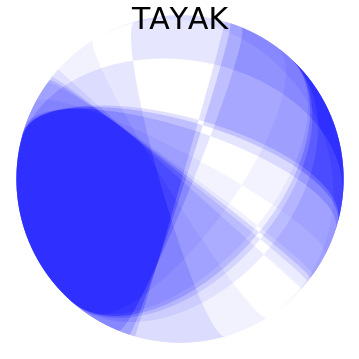

<IPython.core.display.Javascript object>


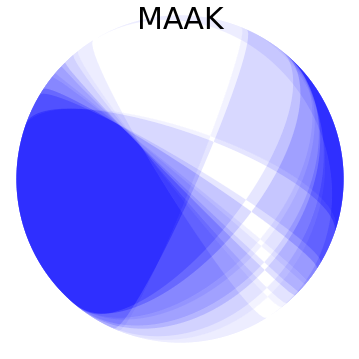

/anaconda3/envs/REU2020/lib/python3.7/site-packages/obspy/imaging/beachball.py:250: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(3, 3), dpi=100)


<IPython.core.display.Javascript object>


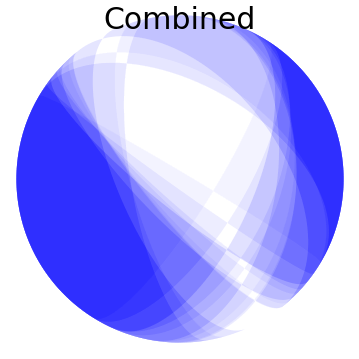

In [60]:
model_bballs(s0173ab_amps_top3)

## S0325ab

<IPython.core.display.Javascript object>


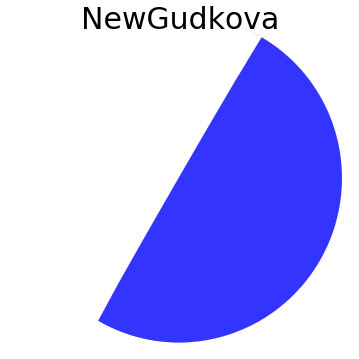

<IPython.core.display.Javascript object>


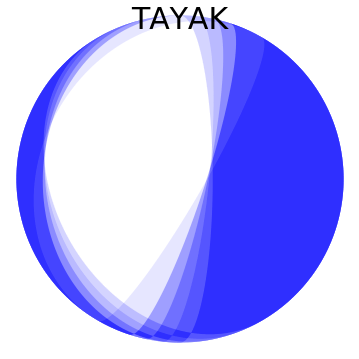

<IPython.core.display.Javascript object>


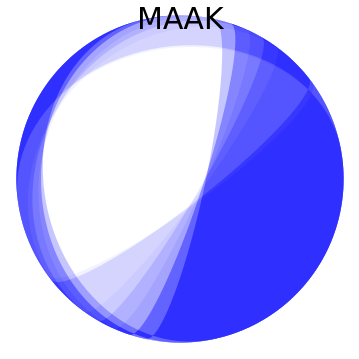

<IPython.core.display.Javascript object>


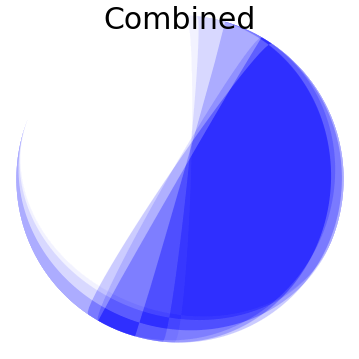

In [62]:
model_bballs(s0325ab_amps_top3)

## 173a

In [ ]:
bbplot('resp_S0173a.csv', 'S0173a')

In [ ]:
s0173a = pd.read_csv(path +'resp_S0173a.csv')
print(len(s0173a))

df1 = s0173a[s0173a['Misfit'] <= 0.1405]

df25 = s0173a[s0173a['Misfit'] <= 2*0.1405]
df2 = df25[df25['Misfit'] > 0.1405]

df35 = s0173a[s0173a['Misfit'] <= 3*0.1405]
df3 = df35[df35['Misfit'] > 2*0.1405]

print(len(df3))
print(len(df1))
print(len(df2))
print(len(df1)+len(df2)+len(df3))

sep_bbplot(df1,'1sigma')
sep_bbplot(df2,'2sigma')
sep_bbplot(df3,'3sigma')

## 173ab

In [ ]:
eca = 0.0961
s0173ab = pd.read_csv(path +'resp_S0173ab.csv')
print(len(s0173ab))

df1 = s0173ab[s0173ab['Misfit'] <= eca]

df25 = s0173ab[s0173ab['Misfit'] <= 2*eca]
df2 = df25[df25['Misfit'] > eca]

df35 = s0173ab[s0173ab['Misfit'] <= 3*eca]
df3 = df35[df35['Misfit'] > 2*eca]

print(len(df3))
print(len(df1))
print(len(df2))
print(len(df1)+len(df2)+len(df3))

sep_bbplot(df1,'1sigma')
sep_bbplot(df2,'2sigma')
sep_bbplot(df3,'3sigma')

## 235b

In [ ]:
eca = 0.1514
s0235b = pd.read_csv(path +'resp_S0235b.csv')
print(len(s0235b))

df1 = s0235b[s0235b['Misfit'] <= eca]

df25 = s0235b[s0235b['Misfit'] <= 2*eca]
df2 = df25[df25['Misfit'] > eca]

df35 = s0235b[s0235b['Misfit'] <= 3*eca]
df3 = df35[df35['Misfit'] > 2*eca]

print(len(df3))
print(len(df1))
print(len(df2))
print(len(df1)+len(df2)+len(df3))

sep_bbplot(df1,'1sigma')
sep_bbplot(df2,'2sigma')
sep_bbplot(df3,'3sigma')

## 325ab

In [ ]:
eca = 0.4984
s0325ab = pd.read_csv(path +'resp_S0325ab.csv')
print(len(s0325ab))

df1 = s0325ab[s0325ab['Misfit'] <= eca]

df25 = s0325ab[s0325ab['Misfit'] <= 2*eca]
df2 = df25[df25['Misfit'] > eca]

df35 = s0325ab[s325ab['Misfit'] <= 3*eca]
df3 = df35[df35['Misfit'] > 2*eca]

print(len(df3))
print(len(df1))
print(len(df2))
print(len(df1)+len(df2)+len(df3))

sep_bbplot(df1,'1sigma')
sep_bbplot(df2,'2sigma')
sep_bbplot(df3,'3sigma')

In [109]:
import matplotlib.pyplot as plot
import numpy as np
from obspy.taup import TauPyModel
import pandas as pd
from pathlib import Path

def getmt(fault):
    rad = 180./np.pi; m0 = 1
    st,dp,rk = fault

    st = st/rad; dp = dp/rad; rk = rk/rad
    sd = np.sin(dp); cd = np.cos(dp)
    sd2 = np.sin(2*dp); cd2 = np.cos(2*dp)
    ss = np.sin(st); cs = np.cos(st)
    ss2 = np.sin(2*st); cs2 = np.cos(2*st)
    sr = np.sin(rk); cr = np.cos(rk)

    # formulas from Aki & Richards Box 4.4
    # mt(1-6): Mrr, Mtt, Mff, Mrt, Mrf, Mtf
    # mt(1-6): Mzz, Mxx, Myy, Mzx, -Mzy, -Mxy
    mt = [ sr*sd2, -1.*sd*cr*ss2 - sd2*sr*ss*ss, sd*cr*ss2 - sd2*sr*cs*cs, -1.*cd*cr*cs - cd2*sr*ss, cd*cr*ss - cd2*sr*cs, -1.*sd*cr*cs2 - 0.5*sd2*sr*ss2]
    return mt

def Rpattern(fault,azimuth,incidence_angles):
    """
    Calculate predicted amplitudes of P, SV, and SH waves.
    IN: fault = [strike, dip, rake]
             = faulting mechanism, described by a list of strike, dip, and rake
             (note, strike is measure clockwise from N, dip is measured positive downwards
             (between 0 and 90) w.r.t. a horizontal that is 90 degrees clockwise from strike,
             and rake is measured positive upwards (counterclockwise)
        azimuth: azimuth with which ray path leaves source (clockwise from N)
        incidence_angles = [i, j]
              i = angle between P ray path & vertical in the source model layer
              j = angle between S ray path & vertical in the source model layer
    OUT: Amplitudes for P, SV, and SH waves
    P as measured on L (~Z) component, SV measured on Q (~R) component, and SH measured on T component.
    All input is in degrees.
    """

    strike,dip,rake = fault
    a = azimuth; rela = strike - azimuth
    sinlam = np.sin(np.radians(rake))
    coslam = np.cos(np.radians(rake))
    sind = np.sin(np.radians(dip))
    cosd = np.cos(np.radians(dip))
    cos2d = np.cos(np.radians(2*dip))
    sinrela = np.sin(np.radians(rela))
    cosrela = np.cos(np.radians(rela))
    sin2rela = np.sin(np.radians(2*rela))
    cos2rela = np.cos(np.radians(2*rela))

    sR = sinlam*sind*cosd
    qR = sinlam*cos2d*sinrela + coslam*cosd*cosrela
    pR = coslam*sind*sin2rela - sinlam*sind*cosd*cos2rela
    pL = sinlam*sind*cosd*sin2rela + coslam*sind*cos2rela
    qL = -coslam*cosd*sinrela + sinlam*cos2d*cosrela

    iP = np.radians(incidence_angles[0])
    jS = np.radians(incidence_angles[1])

    # AP = np.abs(sR*(3*np.cos(iP)**2 - 1) - qR*np.sin(2*iP) - pR*np.sin(iP)**2)
    # ASV = np.abs(1.5*sR*np.sin(2*jS) + qR*np.cos(2*jS) + 0.5*pR*np.sin(2*jS))
    # ASH = np.abs(-qL*np.cos(jS) - pL*np.sin(jS))

    AP = sR*(3*np.cos(iP)**2 - 1) - qR*np.sin(2*iP) - pR*np.sin(iP)**2
    ASV = 1.5*sR*np.sin(2*jS) + qR*np.cos(2*jS) + 0.5*pR*np.sin(2*jS)
    ASH = -qL*np.cos(jS) - pL*np.sin(jS)

    #emperical finding that the SH amplitude should be rotated by 180
    ASH = ASH * -1

    return AP,ASV,ASH

def getamp(azimuth, strike, dip, rake, rayp):
    """
    INPUT:  az = azimuth in degrees from the event to the lander
            st, dp, rk = strike dip rake from 3 separate lists
            Pp, Sp = ray paramters calculated from the model in obspy
            Pvelz, Svelz = velocity @ depth from model
            radius = predefined radius of planet
    OUTPUT: df = dataframe containing synthetic amplitudes
            ip, ij = exit angles (???)
    """
    # define empty lists
    strike_ls = []; dip_ls = []; rake_ls = []
    P_ls = []; SH_ls = []; SV_ls = []

    # loop over fault plane combinations
    for st in strike:
        for dp in dip:
            for rk in rake:
                strike_ls.append(st); dip_ls.append(dp); rake_ls.append(rk)

                # define single fault for calculations
                fault = [st, dp, rk]

                # calculating exit angles using the models velocity @ depth & ray parameters
                # radius should be the radius @ depth
                iP = np.degrees(np.arcsin(Pvelz*rayp[0]/(radius-depth)))
                jS = np.degrees(np.arcsin(Svelz*rayp[1]/(radius-depth)))

                # calculating amplitudes
                P,iSV,iSH = Rpattern(fault, azimuth, [iP, jS])
                scalefactor = (Pvelz/Svelz)**3
                SV,SH = iSV*scalefactor, iSH*scalefactor
                P_ls.append(P); SH_ls.append(SH); SV_ls.append(SV)

    # creating dataframe
    data = {
            'Model': mod,
            'Depth': depth,
            'Strike': strike_ls,
            'Dip': dip_ls,
            'Rake': rake_ls,
            'P': P_ls,
            'SV': SV_ls,
            'SH': SH_ls
            }

    df = pd.DataFrame(data, columns = ['Model','Depth','Strike', 'Dip', 'Rake', 'P', 'SV', 'SH'])
    return df, iP, jS

def eventbuild(event, dist):
    # determine travel times using obspy
    mtimes = mars.get_travel_times(source_depth_in_km= depth, distance_in_degree=dist, phase_list=['P','S'])

    # ray parameters & incidence angles at the station
    Pp = mtimes[0].ray_param ; Pa = mtimes[0].incident_angle

    try:
        Sp = mtimes[1].ray_param ; Sa = mtimes[1].incident_angle
    except:
        Sp = 0 ; Sa = 0
        print('Within S-wave shadow zone')

    print('ray parameters: ', Pp, Sp)
    print('incid angles: ', Pa, Sa)

    return Pp, Sp, Pa, Sa

def autofault(df, obsP, obsSV, obsSH, errP, errS):
    # hypothetically observed amplitudes P, SV, SH:
    vobserved = np.array([obsP, obsSV, obsSH])
    vobslength = np.linalg.norm(vobserved)
    # adding errors:
    eobs = np.array([errP, errS, errS])
    # normalized:
    norm = vobserved/vobslength
    print('normalized array: ',norm)

    # defining cutoff value:
    eca_ls = [eobs[0]*(1-norm[0]),eobs[1]*(1-norm[1]),eobs[2]*(1-norm[2])]/vobslength
    eca = np.arctan(np.max(eca_ls))
    print('cutoff value: ', eca)

    xd = df['P']
    yd = df['SV']
    zd = df['SH']
    ncalc = len(zd)

    len_xd = len(xd); len_yd = len(yd)
    if ncalc != len_xd:
        print('ERROR xd LENGTH')
    if ncalc != len_yd:
        print('ERROR yd LENGHT')

    vcall = np.array([xd,yd,zd])
    vca = vcall.T

    # ------misfit-------
    # empty array
    mf3d = np.zeros(ncalc)

    # list of index values for fault planes below misfit val
    select = []

    for i in np.arange(ncalc):
        # angle in 3 dimensions: (in radians)
        mf3d[i] = np.arccos(np.dot(norm, vca[i])/np.linalg.norm(vca[i]))
        if mf3d[i] < eca:
            select.append(i)

    # pulling fault plane data associated w/ index value
    st_ls = []; dp_ls =[]; rk_ls=[]; mf_ls = []; extra = []
    for i in select:
        st = df.at[i,'Strike']
        dp = df.at[i,'Dip']
        rk = df.at[i,'Rake']
        st_ls.append(st); dp_ls.append(dp); rk_ls.append(rk)

        mf_ls.append(mf3d[i])
        extra.append([depth,i,vca[i],norm])

    faults = {'Strike': st_ls,
                'Dip': dp_ls,
                'Rake': rk_ls,
                'Misfit': mf_ls,
                'Extra': extra}
    posfaults = pd.DataFrame.from_dict(faults)
    # print('before sort: ', posfaults)

    faults_sorted = posfaults.sort_values(by=['Misfit'])
    return faults_sorted


In [174]:
mechanism_dict = {
                    'S0173a': [[60,70,-90],],      #insight mech (march)
                    'S0235b': [[0,40,-80],],      #insight mech (march)

                    }

In [119]:
radius = 3389.5


In [172]:
def forwardcalctrial(dep,mechdic,alt=False):
    if 'S0173a' in mechdic:
        s0173a = mechdic['S0173a'][0]
        if alt == True:
            s0173a_b = mechdic['S0173a'][1]
            
        # ----------- S0173A ---------------
        print('173a')
        Pp, Sp, Pa, Sa = eventbuild('173a', 28.4)
        data173a, Pe, Se = getamp(-87.86, [s0173a[0]], [s0173a[1]], [s0173a[2]], [Pp, Sp])
        print(data173a)

        if alt == True:
            data1, Pe, Se = getamp(-87.86, [s0173a_b[0]], [s0173a_b[1]], [s0173a_b[2]], [Pp, Sp])
            data173a = pd.concat([data173a,data1],ignore_index=True)
            print(data173a)
            
        for i in range(len(data173a)):
            data173a.at[i,'Model'] = 'ForwardCalc'
        data173a.to_csv('/Users/maddysita/Desktop/CIERA_REU/script_notebooks/amps_-87.86.csv', mode='a',header=False)
    else:
        pass
        
    if 'S0173ab' in mechdic:
        s0173ab = mechdic['S0173ab'][0]
        if alt==True:
            s0173a_b = mechdic['S0173a'][1]
            
         #------------ S0173AB ---------------
        print('173ab')
        Pp, Sp, Pa, Sa = eventbuild('173ab', 28.4)
        data173ab, Pe, Se = getamp(-91.37, [s0173ab[0]], [s0173ab[1]], [s0173ab[2]], [Pp, Sp])
        print(data173ab)
    else:
        pass
    
    return
    

In [179]:
def forwardcalc(depth,mechdic,alt=False):
    # ----------- S0173A ---------------
    if 'S0173a' in mechdic:
        s0173a = mechdic['S0173a'][0]
        if alt == True:
            s0173a_b = mechdic['S0173a'][1]
        print(s0173a)

        print('173a')
        Pp, Sp, Pa, Sa = eventbuild('173a', 28.4)
        data173a, Pe, Se = getamp(-87.86, [s0173a[0]], [s0173a[1]], [s0173a[2]], [Pp, Sp])

        if alt == True:
            data1, Pe, Se = getamp(-87.86, [s0173a_b[0]], [s0173a_b[1]], [s0173a_b[2]], [Pp, Sp])
            data173a = pd.concat([data173a,data1],ignore_index=True)

        print(data173a)
        for i in range(len(data173a)):
            data173a.at[i,'Model'] = 'ForwardCalc'
        data173a.to_csv(path+'amps_-87.86.csv', mode='a',header=False)
    else:
        pass


In [180]:
for mod in ['NewGudkova']:
    mars = TauPyModel(model=mod)
    for depth in [35]:
        #Gudkova Model
        if mod == 'NewGudkova':
            if depth <= 50 and depth > 42:
                Pvelz = 7.12500; Svelz = 4.00300    #rounded
            elif depth <= 42 and depth > 21:
                Pvelz = 7.13900; Svelz = 4.01900
            elif depth <=21 and depth > 16:
                Pvelz = 7.14300; Svelz = 4.02300
            elif depth <= 16 and depth > 10:
                Pvelz = 7.15000; Svelz = 4.03000    #rounded

        elif mod == 'TAYAK':
            if depth <= 77 and depth > 10:
                Pvelz = 5.84666; Svelz = 3.28116
            elif depth <= 10 and depth >1:
                Pvelz = 4.95225; Svelz = 2.78097

        elif mod == 'MAAK':
            if depth <= 68 and depth > 10:
                Pvelz = 5.94027; Svelz = 3.33676
            elif depth <= 10 and depth > 1:
                Pvelz = 5.09729; Svelz = 2.86612

        elif mod == 'Combined':
            if depth <= 203 and depth > 50:
                Pvelz = 7.45400; Svelz = 4.21600
            elif depth <= 50 and depth > 22:
                Pvelz = 7.12700; Svelz = 4.00200
            elif depth <= 22 and depth > 8.6:
                Pvelz = 5.14700; Svelz = 2.73900
            elif depth <= 8.6 and depth > 0:
                Pvelz = 3.50400; Svelz = 1.77100
        
        forwardcalc(depth,mechanism_dict)

60
173a
ray parameters:  421.643132989 758.236980663
incid angles:  25.8417212971 23.3393225543


TypeError: 'int' object is not subscriptable

In [132]:
amps_copy = s0173a_amps_top3
print(amps_copy)

    ?       Model  Depth  Strike  Dip  Rake         P        SV        SH
0   0  NewGudkova     35     162   71    56 -0.974253  0.763741 -0.286205
1   0  NewGudkova     45      10   24    96 -0.981320  0.749201 -0.293995
2   0  NewGudkova     55     170   68    68 -0.978603  0.740302 -0.285842
3   0       TAYAK     25     160   89    58 -0.971497  0.747232 -0.305515
4   0       TAYAK     35       2    7    86 -0.977146  0.771863 -0.286115
.. ..         ...    ...     ...  ...   ...       ...       ...       ...
58  0    Combined     45     158   74    50 -0.975607  0.742073 -0.301634
59  0    Combined     45     148   83    34 -0.973588  0.741317 -0.303698
60  0    Combined     55     154   69    42 -0.963683  0.727914 -0.279397
61  0    Combined     55     168   61    64 -0.965409  0.737035 -0.299678
62  0    Combined     55     176   59    76 -0.966858  0.738680 -0.305162

[63 rows x 9 columns]


In [145]:
print(amps_copy)

    ?       Model  Depth  Strike  Dip  Rake         P        SV        SH
0   0  NewGudkova     35     162   71    56 -0.974253  0.763741 -0.286205
1   0  NewGudkova     45      10   24    96 -0.981320  0.749201 -0.293995
2   0  NewGudkova     55     170   68    68 -0.978603  0.740302 -0.285842
3   0       TAYAK     25     160   89    58 -0.971497  0.747232 -0.305515
4   0       TAYAK     35       2    7    86 -0.977146  0.771863 -0.286115
.. ..         ...    ...     ...  ...   ...       ...       ...       ...
58  0    Combined     45     158   74    50 -0.975607  0.742073 -0.301634
59  0    Combined     45     148   83    34 -0.973588  0.741317 -0.303698
60  0    Combined     55     154   69    42 -0.963683  0.727914 -0.279397
61  0    Combined     55     168   61    64 -0.965409  0.737035 -0.299678
62  0    Combined     55     176   59    76 -0.966858  0.738680 -0.305162

[63 rows x 9 columns]


In [157]:
s0173a_amps_trial = pd.read_csv(file_src + 'amps_-87.86.csv')
print(s0173a_amps_trial)

    0      NewGudkova         25         170    68  68.1  -0.977358520547  \
0   0      NewGudkova  35.000000  162.000000  71.0  56.0        -0.974253   
1   0      NewGudkova  45.000000   10.000000  24.0  96.0        -0.981320   
2   0      NewGudkova  55.000000  170.000000  68.0  68.0        -0.978603   
3   0           TAYAK  25.000000  160.000000  89.0  58.0        -0.971497   
4   0           TAYAK  35.000000    2.000000   7.0  86.0        -0.977146   
.. ..             ...        ...         ...   ...   ...              ...   
59  0        Combined  45.000000  148.000000  83.0  34.0        -0.973588   
60  0        Combined  55.000000  154.000000  69.0  42.0        -0.963683   
61  0        Combined  55.000000  168.000000  61.0  64.0        -0.965409   
62  0        Combined  55.000000  176.000000  59.0  76.0        -0.966858   
63  0  0.339238796594   4.803214    2.330055   NaN   NaN              NaN   

    0.753985804527  -0.280887875911  
0         0.763741        -0.286205  